<a href="https://colab.research.google.com/github/manushi0304/Project/blob/main/emailphishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mail-parser
!pip install tldextract



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.2 MB/s eta 0:00:00


In [22]:
import os
from bs4 import BeautifulSoup
import mailparser
from collections import OrderedDict
import email
from urllib.request import urlretrieve
import tarfile
import shutil
import numpy as np
import glob
import mailparser
import re
import tldextract
import urllib.request
import warnings
import logging
import csv
import sys
import logging
import logging.config
import yaml
import pandas as pd
from logging import Formatter
from logging.handlers import RotatingFileHandler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# sns.set_theme()
URLREGEX = r"^(https?|ftp)://[^\s/$.?#].[^\s]*$"
URLREGEX_NOT_ALONE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
FLASH_LINKED_CONTENT = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf"
HREFREGEX = '<a\s*href=[\'|"](.*?)[\'"].*?\s*>'
IPREGEX = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?))\b"
MALICIOUS_IP_URL = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\/(www|http|https|ftp))\b"
EMAILREGEX = r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
GENERAL_SALUTATION = r'\b(dear|hello|Good|Greetings)(?:\W+\w+){0,6}?\W+(user|customer|seller|buyer|account holder)\b'
MAILS_DIR = 'mails'

TAR_DIR = os.path.join(MAILS_DIR, 'tar')


PHISHING_URL = '/content/content/mails/tar/phishing_mails.tar.xz'
HAM_URL = '/content/content/mails/tar/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = '/content/content/mails/tar/20021010_hard_ham.tar.bz2'


with open('/content/logs/config/logging_config.yaml', 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

logging.config.dictConfig(config)
logger = logging.getLogger('PhishingMailClassifier')
logger.debug('often makes a very good meal of %s', 'visiting tourists')
logger.info("Project Started\nConstants defined and libraries imported")

alexa_rank_cache = {}
cache_hit = 0
cache_miss = 0

In [23]:
def download_dataset(url):
    """download and unzip data from a url into the specified path"""
    logger.info("Downloading dataset from '%s'",url)
    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)

    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    print(filename)
    # download the tar file if it doesn't exist
    if not os.path.exists(tarpath):
        urlretrieve(url, tarpath)
        logger.info("Retrieving from URL '%s'",url)

    try:
        tarfile.open(tarpath)
        logger.info("Opened tar '%s'",tarpath)
    except tarfile.ReadError as e:
        logger.error("Error opening tar file '%s': %s", tarpath, e)
        return None


    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(MAILS_DIR, tar.getnames()[0])
        logger.info("Directory Name '%s'",dirname)
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=MAILS_DIR)

        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)

    return dirname

In [24]:

ham_dir = download_dataset(HAM_URL)
logger.info("Downloaded Easy Ham Mails")
hard_ham_dir = download_dataset(HARD_HAM_URL)
logger.info("Downloaded Hard Ham Mails")
phishing_dir = download_dataset(PHISHING_URL)
logger.info("Downloaded Easy Phishing Mails")

20030228_easy_ham_2.tar.bz2
20021010_hard_ham.tar.bz2
phishing_mails.tar.xz


In [25]:

def load_mails(dirpath):
    """load emails from the specified directory"""

    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    logger.info("Loaded mails from '%s'",dirpath)
    return files

In [26]:
# load the datasets
phishing = load_mails(phishing_dir)
print("Number of phishing mails: ",len(phishing))
logger.debug("Number of phishing mails: %d",len(phishing))
ham = load_mails(ham_dir)
ham = ham + load_mails(hard_ham_dir)
print("Number of ham mails: ",len(ham))
logger.debug("Number of ham mails: %d",len(ham))

Number of phishing mails:  2239
Number of ham mails:  1650


In [27]:
phishing = list(set(phishing))
ham = list(set(ham))
print("Number of phishing mails ",len(phishing))
print("Number of ham mails ",len(ham))

Number of phishing mails  2239
Number of ham mails  1631


In [28]:
phishing = list(set(phishing))
ham = list(set(ham))
print("Number of phishing mails ",len(phishing))
print("Number of ham mails ",len(ham))

Number of phishing mails  2239
Number of ham mails  1631


In [29]:
def getMailBody(mail):
    try:
        parsed_mail = mailparser.parse_from_string(mail)
        mail_body = parsed_mail.body.lower()
        subject = parsed_mail.subject
        headers = parsed_mail.headers

    except UnicodeDecodeError as Argument:
        parsed_mail = email.message_from_string(mail)
        body = ""
        if parsed_mail.is_multipart():
            for part in parsed_mail.walk():
                # returns a bytes object
                payload = part.get_payload(decode=True)
                strtext = payload.decode()
                body += strtext
        else:
            payload = parsed_mail.get_payload(decode=True)
            strtext = payload.decode()
            body += strtext
        headers = email.parser.HeaderParser().parsestr(mail)
        mail_body = body.lower()
        subject = headers['Subject']
    return [mail_body,subject,headers]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


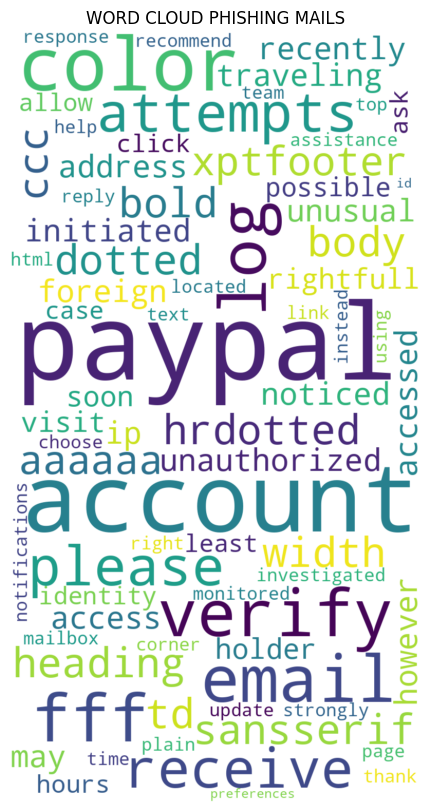

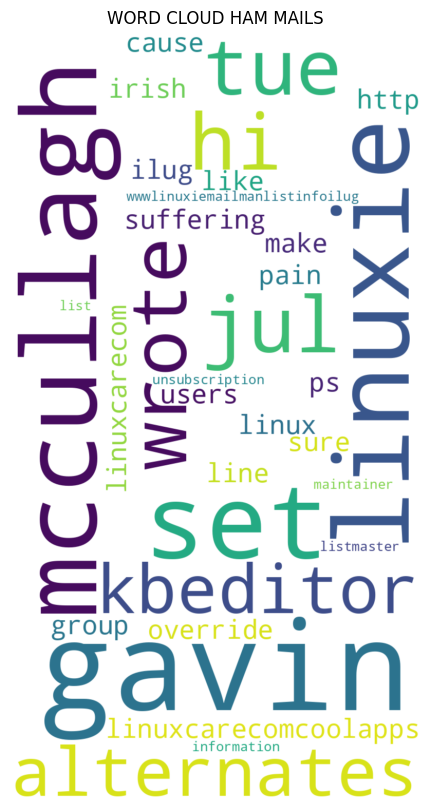

In [33]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from  nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
import textdistance

nltk.download('punkt_tab')

stop_words = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return  cleaned
def filter_words(mails):
    for mail in mails:
        filtered = []
        filtered_text = cleanpunc(cleanhtml(getMailBody(mail)[0]))
        word_tokens = word_tokenize(filtered_text)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
#                     w = lemmatizer.lemmatize(w)
                    filtered.append(w)
    return (filtered)

words_filtered = filter_words(phishing)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=stop_words, max_words = 20000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD PHISHING MAILS")
plt.show()


words_filtered = filter_words(ham)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=stop_words, max_words = 20000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD HAM MAILS")
plt.show()

In [31]:
!pip install textdistance

In [32]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

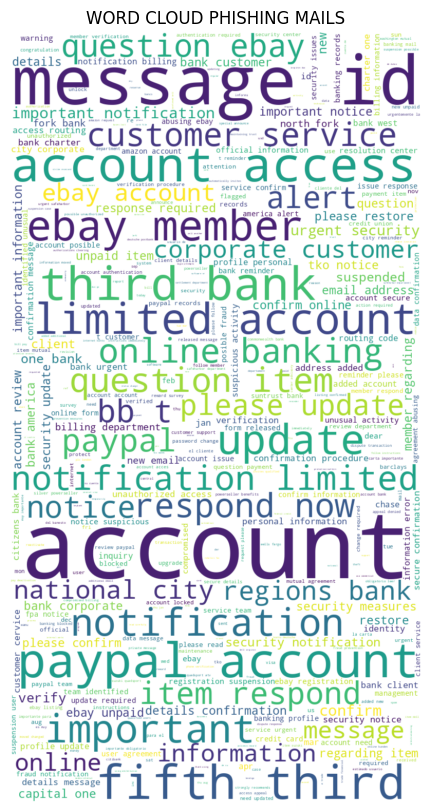

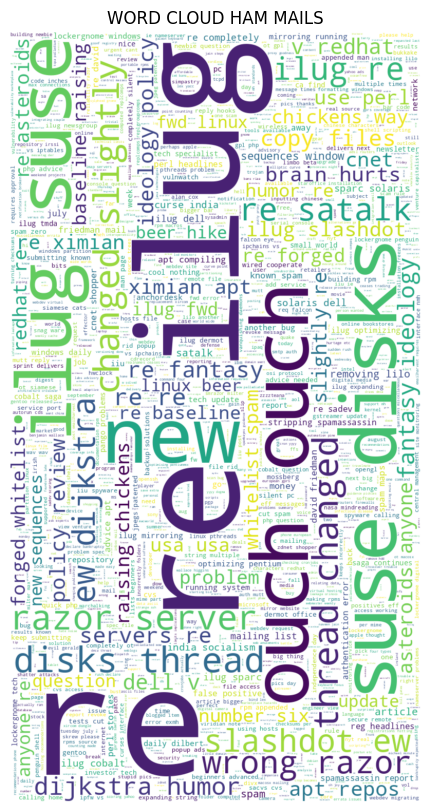

In [34]:
def filter_words(mails):
    all_filtered = []  # Collect words from ALL emails
    for mail in mails:
        filtered_text = getMailBody(mail)[1]
        word_tokens = word_tokenize(filtered_text)
        for w in word_tokens:
            if w not in stop_words and w.isalpha():
                all_filtered.append(w.lower())  # Add .lower() for consistency
    return all_filtered

words_filtered = filter_words(phishing)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=42,stopwords=STOPWORDS, max_words = 20000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD PHISHING MAILS")
plt.show()


words_filtered = filter_words(ham)
text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=42,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.title("WORD CLOUD HAM MAILS")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing phishing emails...
Processing ham emails...


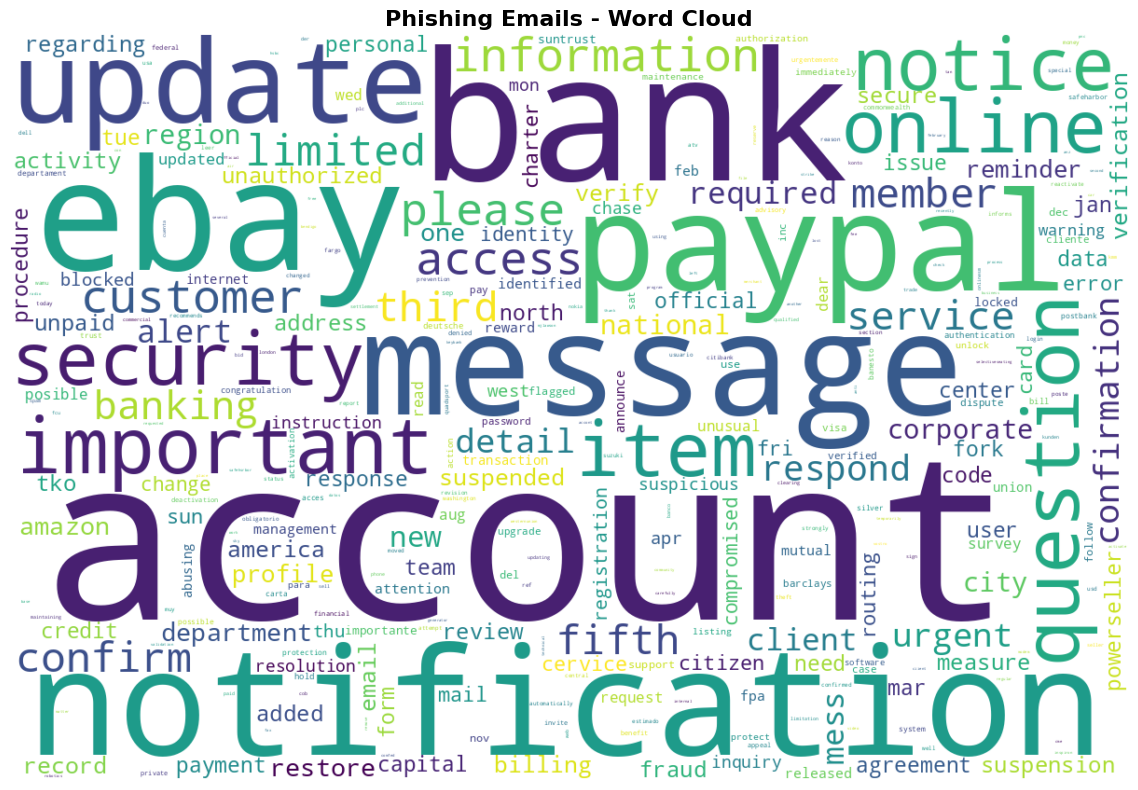

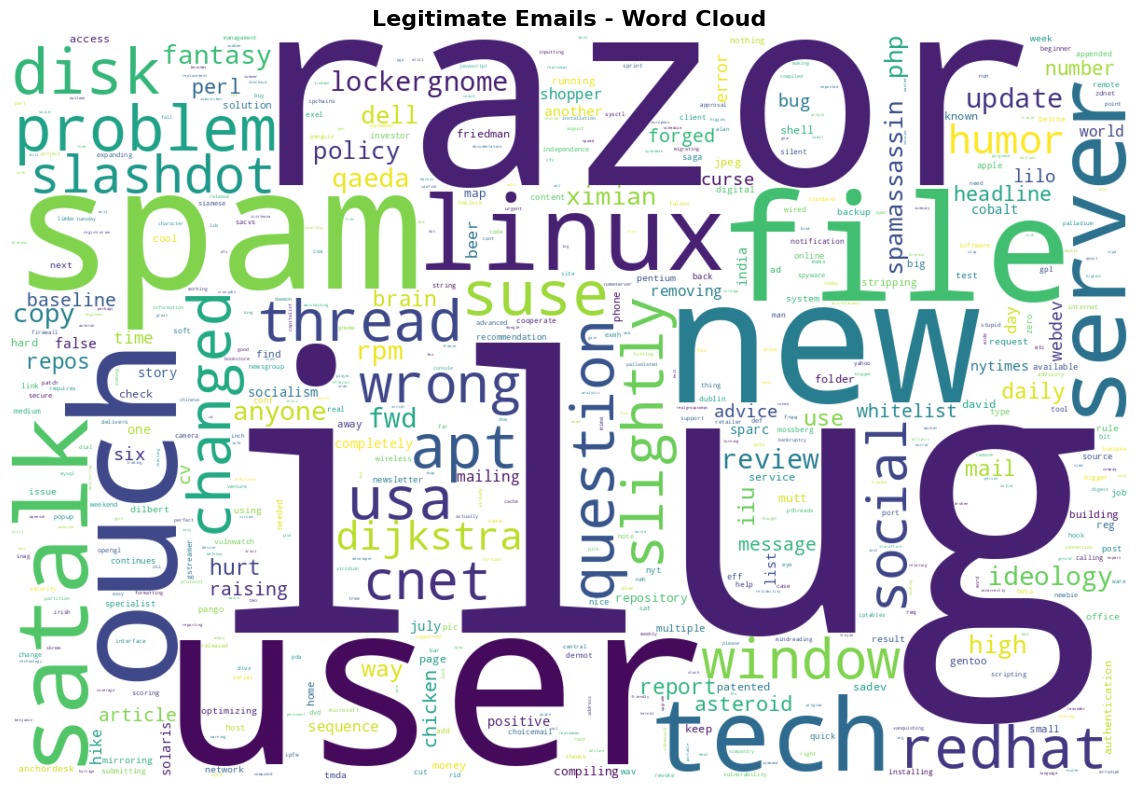

=== VOCABULARY COMPARISON ===

Top 15 Phishing Words:
  account: 786
  bank: 430
  ebay: 314
  notification: 290
  message: 267
  paypal: 244
  update: 216
  important: 201
  question: 199
  item: 188
  security: 185
  online: 183
  notice: 177
  information: 169
  customer: 168

Top 15 Ham Words:
  ilug: 493
  razor: 196
  user: 144
  spam: 71
  file: 51
  ouch: 50
  linux: 49
  tech: 46
  satalk: 45
  server: 43
  problem: 43
  disk: 43
  suse: 42
  apt: 41
  new: 39

Words unique to Phishing: {'item', 'notification', 'ebay', 'bank', 'message', 'account', 'question', 'information', 'paypal', 'update', 'customer', 'security', 'notice', 'important', 'online'}
Words unique to Ham: {'linux', 'satalk', 'server', 'tech', 'spam', 'razor', 'apt', 'disk', 'ouch', 'suse', 'file', 'problem', 'user', 'new', 'ilug'}

Statistics:
Total phishing words: 10196
Unique phishing words: 797
Total ham words: 6683
Unique ham words: 1538


In [35]:
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class EmailTextAnalyzer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Add email-specific stop words
        email_stops = {'subject', 'from', 'to', 'cc', 'bcc', 'date', 'sent',
                      'received', 'reply', 'forward', 'http', 'https', 'www',
                      'com', 'org', 'net', 'html', 'body', 'font', 'div'}
        self.stop_words.update(email_stops)

    def clean_email_text(self, text):
        """Clean and preprocess email text"""
        if not text:
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)

        # Remove email addresses
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def extract_words_from_emails(self, emails):
        """Extract and filter words from multiple emails"""
        all_words = []

        for email in emails:
            try:
                # Extract email body (assuming getMailBody returns tuple)
                email_text = getMailBody(email)[1] if getMailBody(email) else ""

                # Clean the text
                cleaned_text = self.clean_email_text(email_text)

                # Tokenize
                tokens = word_tokenize(cleaned_text)

                # Filter and lemmatize
                for token in tokens:
                    if (len(token) > 2 and  # Skip very short words
                        token.isalpha() and  # Only alphabetic
                        token not in self.stop_words):

                        # Lemmatize to get root form
                        lemmatized = self.lemmatizer.lemmatize(token)
                        all_words.append(lemmatized)

            except Exception as e:
                print(f"Error processing email: {e}")
                continue

        return all_words

    def create_word_cloud(self, words, title, max_words=5000, figsize=(12, 8)):
        """Create and display word cloud"""
        if not words:
            print(f"No words found for {title}")
            return None

        # Join words into text
        text = " ".join(words)

        # Create word cloud with consistent parameters
        wordcloud = WordCloud(
            background_color="white",
            max_words=max_words,
            width=1200,
            height=800,
            random_state=42,
            stopwords=STOPWORDS,
            collocations=False,  # Avoid word pairs
            relative_scaling=0.5
        ).generate(text)

        # Display
        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        return wordcloud

    def get_word_frequencies(self, words, top_n=20):
        """Get most frequent words"""
        word_freq = Counter(words)
        return word_freq.most_common(top_n)

    def compare_vocabularies(self, phishing_words, ham_words, top_n=15):
        """Compare vocabularies between phishing and ham emails"""
        phishing_freq = Counter(phishing_words)
        ham_freq = Counter(ham_words)

        # Get top words from each category
        phishing_top = dict(phishing_freq.most_common(top_n))
        ham_top = dict(ham_freq.most_common(top_n))

        # Find words unique to each category
        phishing_unique = set(phishing_top.keys()) - set(ham_top.keys())
        ham_unique = set(ham_top.keys()) - set(phishing_top.keys())

        print("=== VOCABULARY COMPARISON ===")
        print(f"\nTop {top_n} Phishing Words:")
        for word, count in phishing_freq.most_common(top_n):
            print(f"  {word}: {count}")

        print(f"\nTop {top_n} Ham Words:")
        for word, count in ham_freq.most_common(top_n):
            print(f"  {word}: {count}")

        print(f"\nWords unique to Phishing: {phishing_unique}")
        print(f"Words unique to Ham: {ham_unique}")

# Usage Example
analyzer = EmailTextAnalyzer()

# Extract words from emails
print("Processing phishing emails...")
phishing_words = analyzer.extract_words_from_emails(phishing)

print("Processing ham emails...")
ham_words = analyzer.extract_words_from_emails(ham)

# Create word clouds with consistent parameters
analyzer.create_word_cloud(phishing_words, "Phishing Emails - Word Cloud", max_words=5000)
analyzer.create_word_cloud(ham_words, "Legitimate Emails - Word Cloud", max_words=5000)

# Compare vocabularies
analyzer.compare_vocabularies(phishing_words, ham_words)

# Get statistics
print(f"\nStatistics:")
print(f"Total phishing words: {len(phishing_words)}")
print(f"Unique phishing words: {len(set(phishing_words))}")
print(f"Total ham words: {len(ham_words)}")
print(f"Unique ham words: {len(set(ham_words))}")

In [36]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned



def cleanBody(mail_body):
        filtered = []
        filtered_text = cleanpunc(cleanhtml(mail_body))
        word_tokens = word_tokenize(filtered_text)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
                    filtered.append(w)
        return filtered

def presenceHTML(mail):
    msg = email.message_from_string(mail)
    return int((msg.get_content_type() == 'text/html') == True)


def presenceHTMLFORM(message):
    return int((re.compile(r'<\s?\/?\s?form\s?>', re.IGNORECASE).search(message)
             != None) == True)


def presenceHTMLIFRAME(message):
    return int(re.compile(r'<\s?\/?\s?iframe\s?>',
                      re.IGNORECASE).search(message) != None) == True


def presenceJavaScript(message):
    return int(re.compile(r'<\s?\/?\s?script\s?>',
                      re.IGNORECASE).search(message) != None) == True


def presenceFlashContent(message):
    swflinks = re.compile(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf",
        re.IGNORECASE).findall(message)
    flashObject = re.compile(r'embed\s*src\s*=\s*\".*\.swf\"',
                             re.IGNORECASE).search(message)
    return int((swflinks != None and len(swflinks) > 0) or (flashObject != None)) == True


def presenceGeneralSalutation(message):
    return int(re.compile(GENERAL_SALUTATION,re.IGNORECASE).search(message) != None) == True


def numberOfAttachments(raw_mail):
    try:
        mail = mailparser.parse_from_string(raw_mail)
        count = len(mail.attachments)
        return count
    except:
        return 0

def mail_to(mail_body):
    return int(re.compile(r'mailto:',
                      re.IGNORECASE).search(mail_body) != None) == True

def popups(mail_body):
    if re.compile(r'window.open|onclick',re.IGNORECASE).search(mail_body):
         return 1
    return 0

def body_richness(mail_body):
    mail_body = cleanBody(mail_body)
    if len(set(mail_body))!=0:
        return (len(mail_body)/len(set(mail_body)))
    else:
        return len(mail_body)

In [37]:
def isURL(link):
    return re.compile(URLREGEX, re.IGNORECASE).search(link) is not None


def getURLs(mail_body):
    result = []
    cleanPayload = re.sub(r'\s+', ' ', mail_body)
    soup = BeautifulSoup(cleanPayload, 'html.parser')
    links = soup.find_all('a')
    i = 0
    for link in links:
        links[i] = link.get('href')
        i += 1

    for link in links:
        if isinstance(link, str) or isinstance(link, bytes):
            if isURL(link):
                result.append(link)
        else:
            continue

    urlregex = re.compile(URLREGEX_NOT_ALONE, re.IGNORECASE)
    links = urlregex.findall(cleanPayload)

    for link in links:
        if link not in result:
            result.append(link)

    res = list(OrderedDict.fromkeys(result))
    result = list(set(result))
    return result


def IPasURL(urls):
    result = []
    count = 0
    for url in urls:
        if re.compile(IPREGEX, re.IGNORECASE).search(url) and re.compile(IPREGEX, re.IGNORECASE).search(url).group(1) is not None:
            result.append(re.compile(IPREGEX, re.IGNORECASE).search(url).group(1))
            count += 1
    return count


def textLinkDisparity(mail_body):
    count = 0
    soup = BeautifulSoup(mail_body, 'html.parser')
    lists = soup.find_all('a')
    for item in lists:
        link = item.get('href')
        for string in item.stripped_strings:
            text = str(string)
            text = text.strip().replace('\n', '')
            text = text.strip().replace('\t', ' ')
            if isURL(text) and text != link:
                count += 1
    return count


def maliciousURL(urls):
    count = 0
    for url in urls:
        if ((re.compile(IPREGEX, re.IGNORECASE).search(url)
             is not None) == True or (len(re.compile(r'(https?://)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(www.)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(\.com|\.org|\.co)',re.IGNORECASE).findall(url)) > 1))== True:
            count += 1
    return count


def hexadecimalURL(urls):
    count = 0
    for url in urls:
        if ((re.compile(r'%[0-9a-fA-F]+', re.IGNORECASE).search(url)
             is not None) == True):
            count += 1
    return count


def getAlexaRank(domain):
    if domain in alexa_rank_cache:
#         cache_hit +=1
        return int(alexa_rank_cache[domain])
#     else:
#         cache_miss += 1
    try:
        xml = urllib.request.urlopen(
            'http://data.alexa.com/data?cli=10&dat=s&url=%s' %
            domain).read().decode('utf-8')
    except:
        alexa_rank_cache[domain] = 0
        return 0
    try:
        rank = (re.compile(r'RANK="(\d+)"',re.IGNORECASE).findall(xml))[1]
    except:
        rank = -1
    alexa_rank_cache[domain] = rank
    return int(rank)


def extractDomains(urls):
    domain_set = set()
    for url in urls:
        domain = tldextract.extract(url).registered_domain
        if domain not in domain_set:
            domain_set.add(domain)
        else:
            continue

    return list(domain_set)


def domainCounts(url):
    domains = tldextract.extract(url)
    count = (len(re.compile(r'\.',re.IGNORECASE).findall( domains.subdomain))) + \
        ((len(re.compile(r'\.',re.IGNORECASE).findall( domains.domain)))+1)
    if re.compile(IPREGEX,re.IGNORECASE).search(domains.domain) is not None:
        count -= 3
    return (count)


def presenceBadRankedURL(urls):
    domains = extractDomains(urls)
    max_rank = 0
    for domain in domains:
        rank = getAlexaRank(domain)
        max_rank = max(rank, max_rank)
        if rank == -1:
            return 0
    if max_rank > 70000:
        return 1
    return 0

def maxDomainsCounts(urls):
    count = 1
    for url in urls:
        count = max(domainCounts(url), count)
    return count

def at_in_url(urls):
    for url in urls:
        if (re.compile(r'@',re.IGNORECASE).search(url)):
            return 1
        else:
            continue
    return 0
import json
import ast
def writeCache():
    with open('/content/cache/alexa_rank_cache.txt', 'w') as cache_file:
        cache_file.write(json.dumps(alexa_rank_cache))
        logger.info("Cache written")


def loadCache():
    try:
        with open('/content/cache/alexa_rank_cache.txt','r') as cache_file:
            cache = ast.literal_eval(cache_file.read())
            alexa_rank_cache = cache
            logger.info("Cache loaded")
    except FileNotFoundError:
        log.warning("No alexa rank cache found")

In [38]:
def isRepliedMail(subject):
    return (subject).startswith('Re:')

def isForwardedMail(subject):
    return (subject).startswith('Fwd:')

def subject_richness(subject):
    texts = subject.split()
    if len(set(texts))!=0:
        return (len(texts)/len(set(texts)))
    else:
        return len(texts)
def contains_verify(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if (jaro('verify',w)) >0.9:
            return 1
     return 0

def contains_update(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if (jaro('update',w)) >0.9:
            return 1
     return 0

def contains_access(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if (jaro('access',w)) >0.9:
            return 1
     return 0
# def get_top_n_words(corpus, n=None):
#     filtered = []
#     for word in corpus:
#         word = stemmer.stem(word)
#         word = lemmatizer.lemmatize(word)
#         filtered+=word
#     corpus = set(filtered)
#     vec = CountVectorizer().fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0)
#     words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:n]

# body = ""
# for mail in phishing:
#     body += getMailBody(mail)[0]
#     body+=" "
# print(get_top_n_words(body))
def contains_prime_targets(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if ((jaro('bank',w)) >0.9 or (jaro('Paypal',w)) >0.9 or (jaro('ebay',w)) >0.9 or (jaro('amazon',w)) >0.9):
            return 1
     return 0

def contains_account(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if (jaro('account',w)) >0.9 or jaro('profile',w) >0.9 or jaro('handle',w) >0.9 :
            return 1
     return 0

def contains_suspended(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if (((jaro('closed',w)) or jaro('expiration',w))or jaro('suspended',w)) >0.9 or jaro('terminate',w) >0.9 or jaro('restricted',w) >0.9:
            return 1
     return 0

def contains_password(subject):
     subject = purify(subject)
     jaro = textdistance.Jaro()
     for w in subject.split():

         if (jaro('password',w)) >0.9 or jaro('credential',w) > 0.9:
            return 1
     return 0

def contains_urgent(subject):
    subject = purify(subject)
    jaro = textdistance.Jaro()
    for w in subject.split():
        if (jaro('urgent',w)) >0.9 or jaro('immediate',w) >0.9:
           return 1
    return 0

def purify(subject):
    filtered = ""
    word_tokens = word_tokenize(subject)
    for w in word_tokens:
         if w not in stop_words and w.isalpha():
                   w = stemmer.stem(w)
                   filtered+=(lemmatizer.lemmatize(w))
                   filtered+=" "
    return filtered

In [39]:
import re

def number_of_dots(headers):
    try:
        sender = headers["From"]
    except KeyError:
        sender = headers["from"]

    # Handle case where sender is a list
    if isinstance(sender, list):
        sender = sender[0] if sender else ""
    elif sender is None:
        sender = ""
    else:
        sender = str(sender)  # Ensure it's a string

    return len(re.compile(r'\.', re.IGNORECASE).findall(sender))

def number_of_dash(headers):
    try:
        sender = headers["From"]
    except KeyError:
        sender = headers["from"]

    # Handle case where sender is a list
    if isinstance(sender, list):
        sender = sender[0] if sender else ""
    elif sender is None:
        sender = ""
    else:
        sender = str(sender)  # Ensure it's a string

    return len(re.compile(r'-', re.IGNORECASE).findall(sender))

# More robust version with helper function
def get_sender_from_headers(headers):
    """Extract sender email as string from headers"""
    sender = None

    # Try different variations of the from field
    for field in ["From", "from", "SENDER", "sender"]:
        try:
            sender = headers[field]
            break
        except KeyError:
            continue

    # If no sender found, return empty string
    if sender is None:
        return ""

    # Handle different data types
    if isinstance(sender, list):
        sender = sender[0] if sender else ""

    # Convert to string and clean up
    sender = str(sender).strip()

    return sender

# Refactored functions using helper
def number_of_dots(headers):
    sender = get_sender_from_headers(headers)
    return len(re.findall(r'\.', sender))

def number_of_dash(headers):
    sender = get_sender_from_headers(headers)
    return len(re.findall(r'-', sender))

def number_of_underscores(headers):
    sender = get_sender_from_headers(headers)
    return len(re.findall(r'_', sender))

def number_of_digits(headers):
    sender = get_sender_from_headers(headers)
    return len(re.findall(r'\d', sender))

# Debug function to inspect what's actually in your headers
def debug_sender_field(headers, email_index=0):
    """Debug what's in the sender field"""
    print(f"\n=== Email {email_index} Sender Debug ===")

    for field in ["From", "from", "SENDER", "sender"]:
        if field in headers:
            value = headers[field]
            print(f"{field}: '{value}' (type: {type(value)})")
            if isinstance(value, list):
                print(f"  List contents: {[str(item) for item in value]}")

    sender = get_sender_from_headers(headers)
    print(f"Final sender string: '{sender}'")
    print(f"Dots: {number_of_dots(headers)}")
    print(f"Dashes: {number_of_dash(headers)}")

In [40]:
filename = "/content/dataset/mails_dataset.csv"
fields = [
     "HTML", "HTMLForm", "IFrame", "FlashContent", "General Salutation",
    "Javascript", "mailto:","popups","body richness","Number of URLs", "Malicious URL", "text link disparity",
    "Attachments", "IP URLs", "hexadecimal URL", "Bad Rank Domain",
    "Maximum Domains Counts","@_in_url","Subject richness","Fwd: mail","Re: mail","contains account","contains verify",
    "contains update","contains prime targets","contains suspension","contains password","contains urgent","contains access",
    "number of dots","number of dash","Class"
]
rows = []


def constructDataSet(messages, label):
    i = 1

    for mail in messages:
        parsed_mail = getMailBody(mail)

        mail_body = parsed_mail[0]
        mail_subject = parsed_mail[1]
        mail_headers = parsed_mail[2]

        urls = getURLs(mail_body)
        feature = [0] * (len(fields))
        i = 0
        feature[i]= int(presenceHTML(mail)==True)
        i+=1
        feature[i]= int(presenceHTMLFORM(mail_body)==True)
        i+=1
        feature[i]= int(presenceHTMLIFRAME(mail_body)==True)
        i+=1
        feature[i]= int(presenceFlashContent(mail_body)==True)
        i+=1
        feature[i]= int(presenceGeneralSalutation(mail_body)==True)
        i+=1
        feature[i]= int(presenceJavaScript(mail_body)==True)
        i+=1
        feature[i]= int(mail_to(mail_body)==True)
        i+=1
        feature[i]= popups(mail_body)
        i+=1
        feature[i] = body_richness(mail_body)
        i+=1
        feature[i]= len(urls)
        i+=1
        feature[i]= (maliciousURL(urls))
        i+=1
        feature[i]= textLinkDisparity(mail_body)
        i+=1
        feature[i] = numberOfAttachments(mail)
        i+=1
        feature[i] = (IPasURL(urls))
        i+=1
        feature[i] = (hexadecimalURL(urls))
        i+=1
        feature[i] = int(presenceBadRankedURL(urls)==True)
        i+=1
        feature[i] = (maxDomainsCounts(urls))
        i+=1
        feature[i]= at_in_url(urls)
        i+=1
        feature[i] = subject_richness(mail_subject)
        i+=1
        feature[i]= int(isForwardedMail(mail_subject)==True)
        i+=1
        feature[i]= int(isRepliedMail(mail_subject)==True)
        i+=1
        feature[i]= int(contains_account(mail_subject)== True)
        i+=1
        feature[i]= int(contains_verify(mail_subject)==True)
        i+=1
        feature[i]= int(contains_update(mail_subject)==True)
        i+=1
        feature[i]= int(contains_prime_targets(mail_subject)==True)
        i+=1
        feature[i]= int(contains_suspended(mail_subject)==True)
        i+=1
        feature[i]= int(contains_password(mail_subject)==True)
        i+=1
        feature[i]= int(contains_urgent(mail_subject)==True)
        i+=1
        feature[i] = int(contains_access(mail_subject)==True)
        i+=1
        feature[i]= number_of_dots(mail_headers)
        i+=1
        feature[i]= number_of_dash(mail_headers)
        i+=1
        feature[i] = label
        rows.append(feature)

In [41]:
def writeCSV():
    with open(filename, 'w', newline='') as csvfile:

        # creating a csv writer object
        csvwriter = csv.writer(csvfile)

        # writing the fields
        csvwriter.writerow(fields)

        # writing the data rows
        csvwriter.writerows(rows)
        logger.info("CSV written to %s",filename)
        print("written CSV")

In [42]:
rows.clear()
loadCache()
logger.debug("Started Constructing Dataset for Ham mail")
print("HAM MAILS")
constructDataSet(ham, "Ham")
# print(rows)
print("PHISHING MAILS")
logger.debug("Started Constructing Dataset for Phishing mail")
constructDataSet(phishing, "Phishing")
writeCSV()
writeCache()

HAM MAILS
PHISHING MAILS
written CSV


In [43]:
mails = pd.read_csv("/content/dataset/mails_dataset.csv")
print("Number of Ham class records: ",len(mails[mails['Class'] == 'Ham']))
print("Number of Phishing class records: ",len(mails[mails['Class'] == 'Phishing']))

Number of Ham class records:  1631
Number of Phishing class records:  2239


In [44]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()
mails = pd.read_csv("./dataset/mails_dataset.csv")

labels=le.fit_transform(mails['Class'])

mails.drop('Class',axis =1,inplace=True)



X_train, X_test, Y_train, Y_test = train_test_split(mails,
                                                    labels,
                                                    test_size=0.20,
                                                    stratify=labels,
                                                    random_state=42)
# check dataset shapes
print(X_train.shape, (Y_train).shape)

(3096, 31) (3096,)


In [45]:
mails = X_train.copy(deep=True)
mails['Class'] =  pd.Series(Y_train, index=mails.index)

mails.describe()

HTML     HTMLForm       IFrame  FlashContent  \
count  3096.000000  3096.000000  3096.000000   3096.000000   
mean      0.317506     0.038437     0.016796      0.000969   
std       0.465581     0.192279     0.128527      0.031119   
min       0.000000     0.000000     0.000000      0.000000   
25%       0.000000     0.000000     0.000000      0.000000   
50%       0.000000     0.000000     0.000000      0.000000   
75%       1.000000     0.000000     0.000000      0.000000   
max       1.000000     1.000000     1.000000      1.000000   

       General Salutation   Javascript      mailto:       popups  \
count         3096.000000  3096.000000  3096.000000  3096.000000   
mean             0.118217     0.043605     0.058786     0.041667   
std              0.322917     0.204247     0.235261     0.199859   
min              0.000000     0.000000     0.000000     0.000000   
25%              0.000000     0.000000     0.000000     0.000000   
50%              0.000000     0.000000     0.000000     0.000000   
75%              0.000000     0.000000     0.000000     0.000000   
max              1.000000     1.000000     1.000000     1.000000   

       body richness  Number of URLs  ...  contains verify  contains update  \
count    3096.000000     3096.000000  ...      3096.000000      3096.000000   
mean        1.593774        8.736757  ...         0.012274         0.066214   
std         0.741978       58.165627  ...         0.110123         0.248697   
min         0.000000        0.000000  ...         0.000000         0.000000   
25%         1.229167        2.000000  ...         0.000000         0.000000   
50%         1.415385        2.000000  ...         0.000000         0.000000   
75%         1.709677        6.000000  ...         0.000000         0.000000   
max        20.250000     3117.000000  ...         1.000000         1.000000   

       contains prime targets  contains suspension  contains password  \
count             3096.000000          3096.000000        3096.000000   
mean                 0.205749             0.000646           0.003876   
std                  0.404313             0.025412           0.062147   
min                  0.000000             0.000000           0.000000   
25%                  0.000000             0.000000           0.000000   
50%                  0.000000             0.000000           0.000000   
75%                  0.000000             0.000000           0.000000   
max                  1.000000             1.000000           1.000000   

       contains urgent  contains access  number of dots  number of dash  \
count      3096.000000      3096.000000     3096.000000     3096.000000   
mean          0.023256         0.045866        1.650840        0.218023   
std           0.150739         0.209227        0.977213        0.507722   
min           0.000000         0.000000        0.000000        0.000000   
25%           0.000000         0.000000        1.000000        0.000000   
50%           0.000000         0.000000        1.000000        0.000000   
75%           0.000000         0.000000        2.000000        0.000000   
max           1.000000         1.000000        8.000000        7.000000   

             Class  
count  3096.000000  
mean      0.578488  
std       0.493881  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  

[8 rows x 32 columns]

In [46]:
#checking for missing values
# print(mails.isnull().sum())
mails.drop_duplicates(keep = "first", inplace = True)
print("Number of Ham class records: ",len(mails[mails['Class'] == 0]))
print("Number of Phishing class records: ",len(mails[mails['Class'] == 1]))
labels = mails['Class']
mails.drop('Class',axis=1,inplace=True)
mails.tail()

Number of Ham class records:  1253
Number of Phishing class records:  1474


HTML  HTMLForm  IFrame  FlashContent  General Salutation  Javascript  \
1656     0         0       0             0                   0           0   
3787     1         0       0             0                   0           0   
494      0         0       0             0                   0           0   
22       0         0       0             0                   0           0   
2381     0         0       0             0                   1           0   

      mailto:  popups  body richness  Number of URLs  ...  contains account  \
1656        0       0       1.114583               2  ...                 0   
3787        0       0       1.255319               3  ...                 1   
494         0       0       1.197368               1  ...                 0   
22          0       0       1.064516               1  ...                 0   
2381        0       0       1.403846               2  ...                 0   

      contains verify  contains update  contains prime targets  \
1656                1                0                       1   
3787                0                0                       0   
494                 0                0                       0   
22                  0                0                       0   
2381                0                0                       1   

      contains suspension  contains password  contains urgent  \
1656                    0                  0                0   
3787                    0                  0                0   
494                     0                  0                0   
22                      0                  0                0   
2381                    0                  0                0   

      contains access  number of dots  number of dash  
1656                0               1               1  
3787                0               1               1  
494                 0               1               0  
22                  0               1               0  
2381                0               3               0  

[5 rows x 31 columns]

<Axes: >

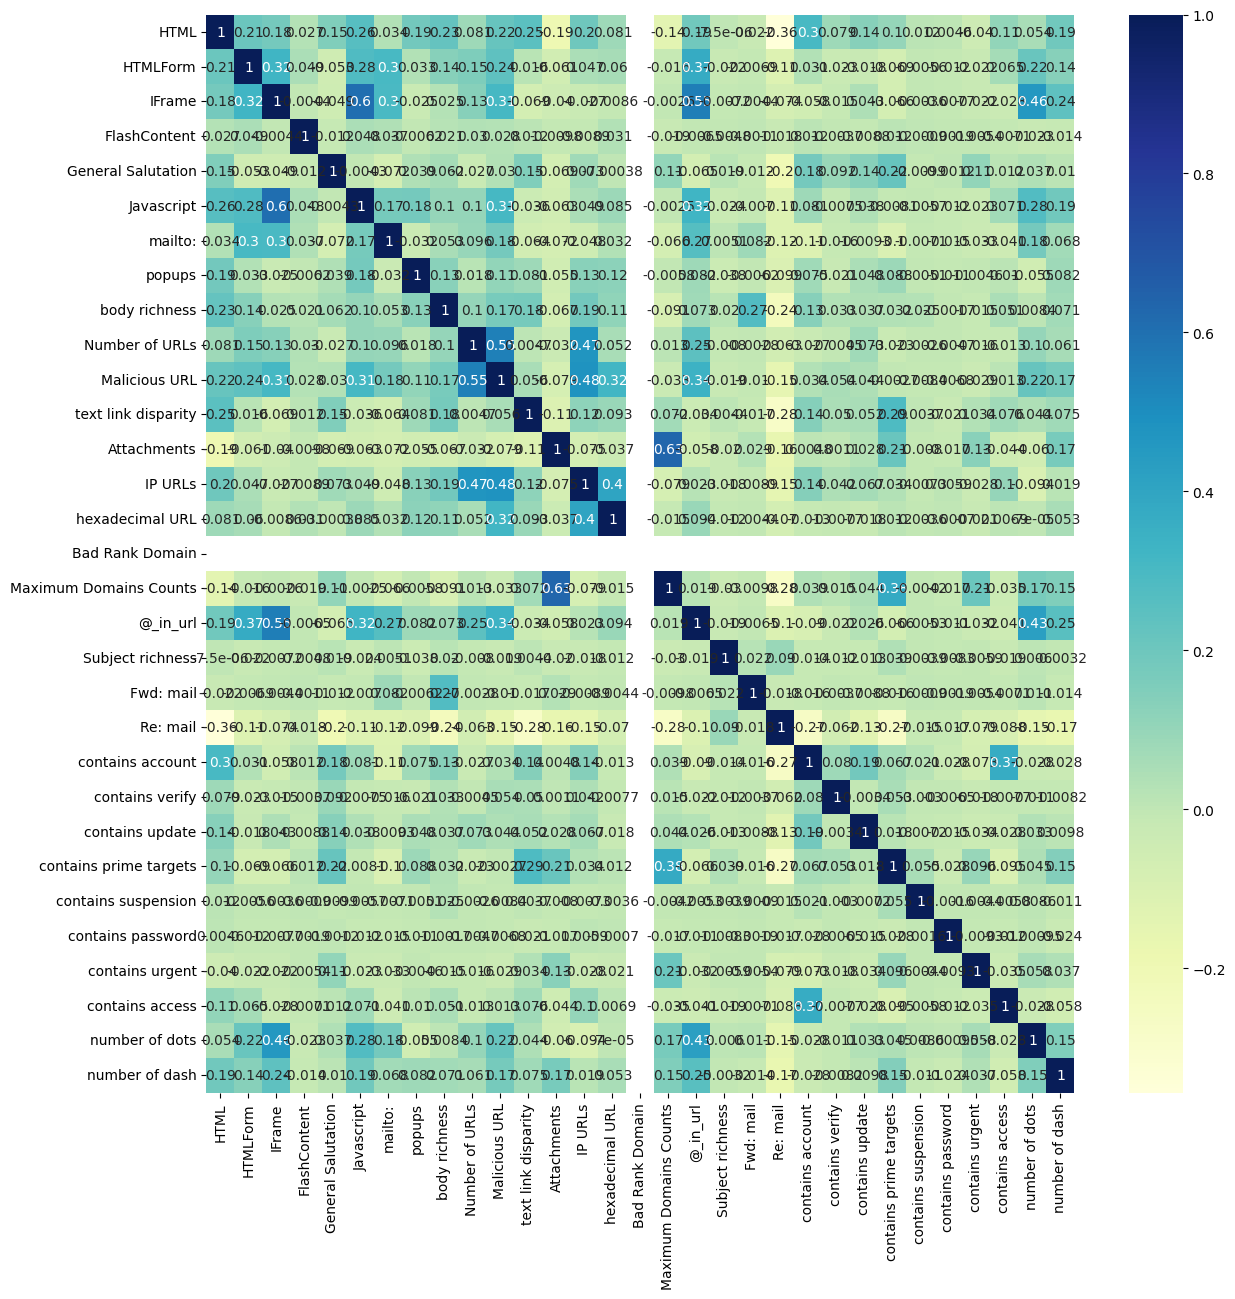

In [47]:
%matplotlib inline
plt.figure(figsize = (14,14))
sns.heatmap(mails.corr(),annot=True,cmap="YlGnBu")

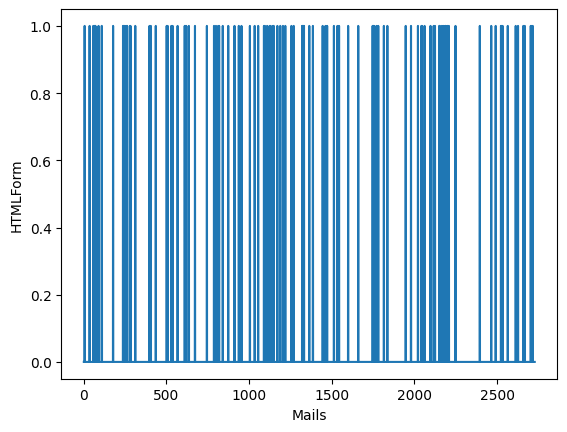

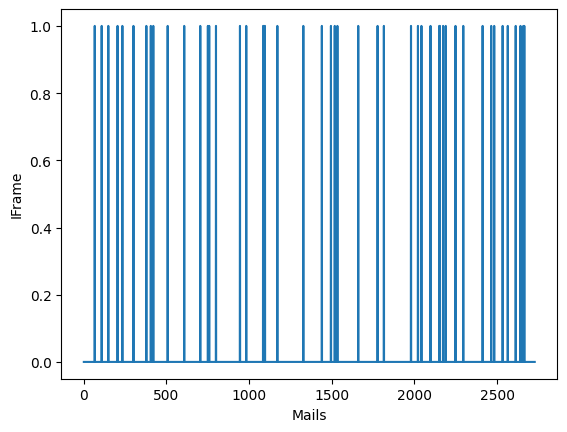

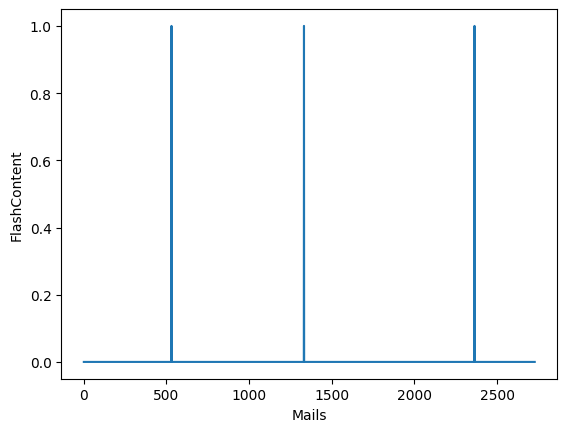

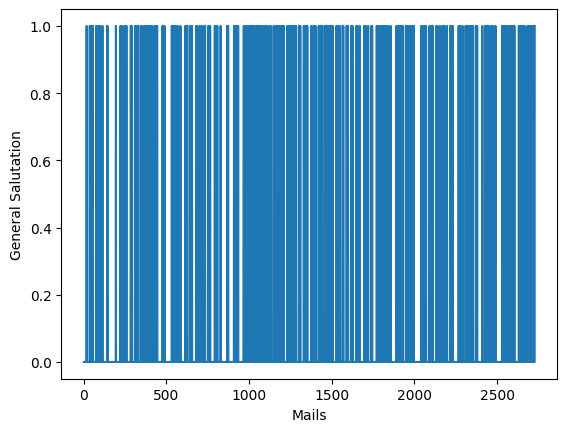

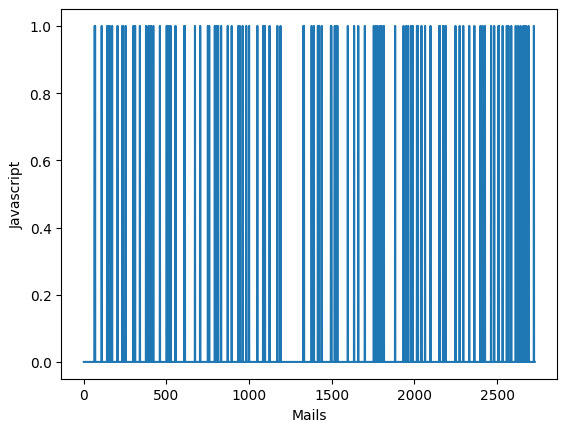

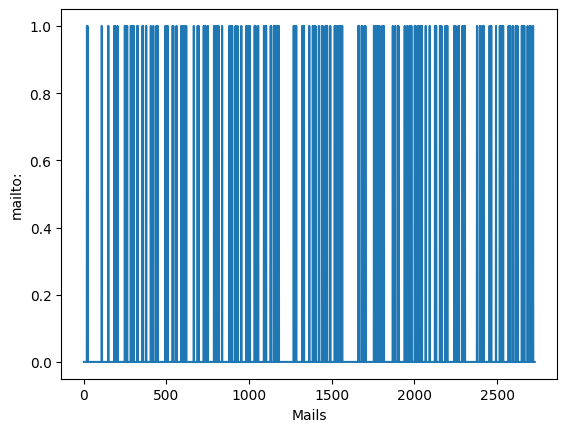

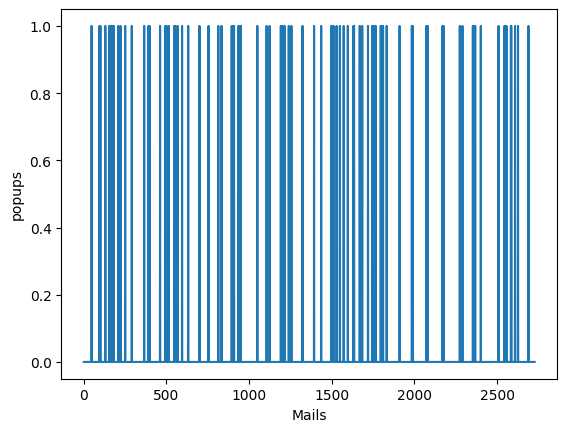

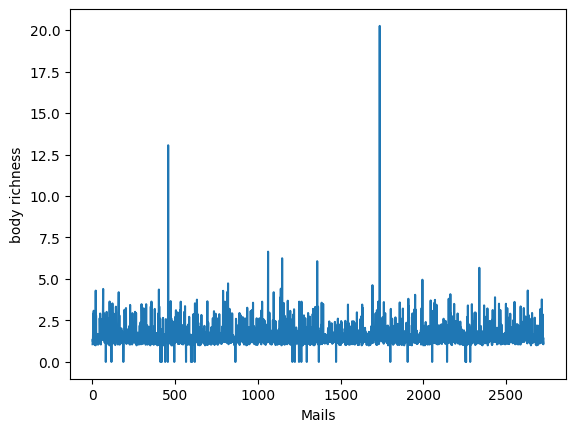

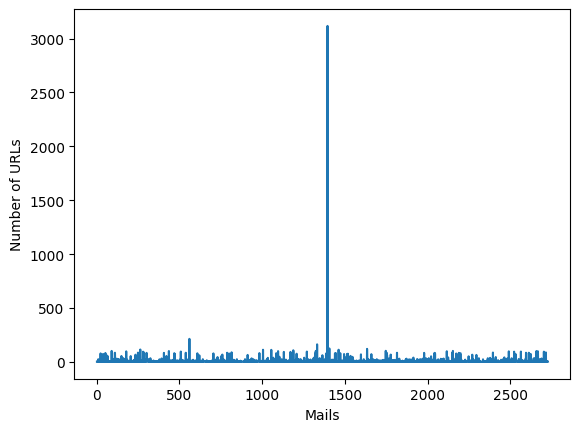

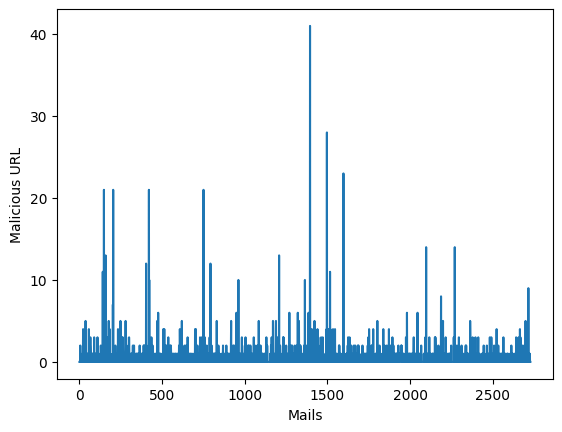

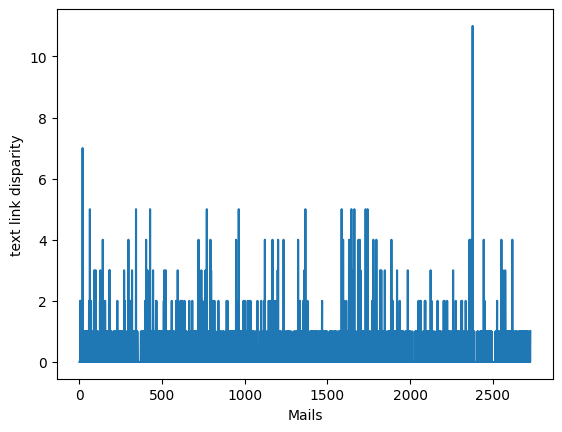

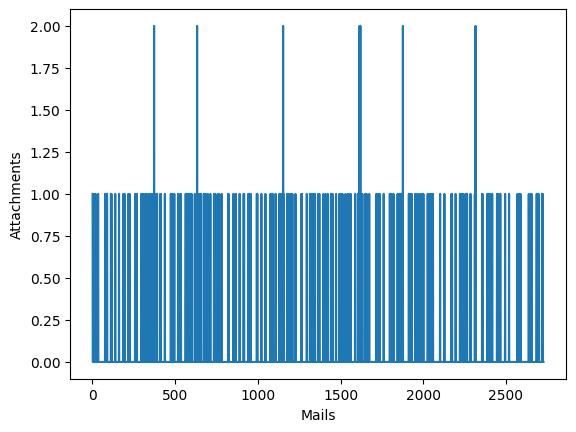

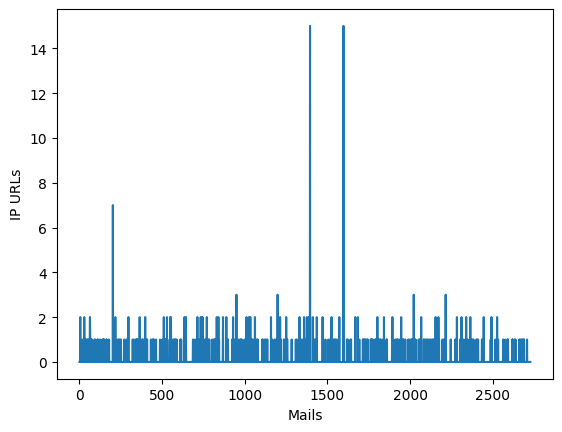

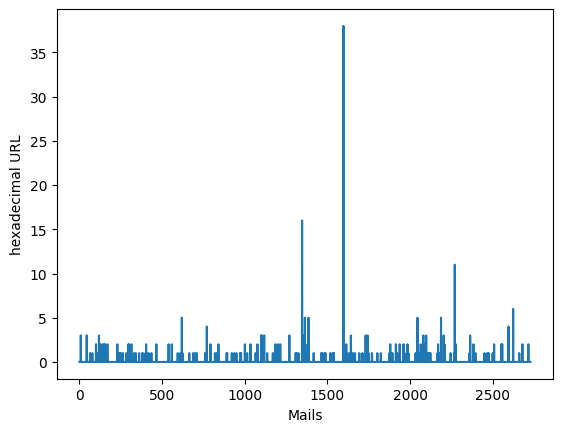

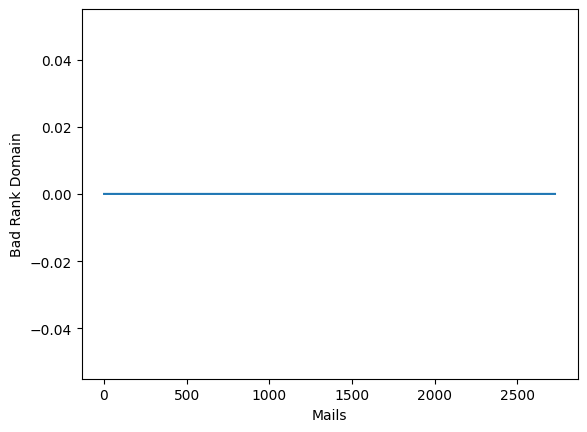

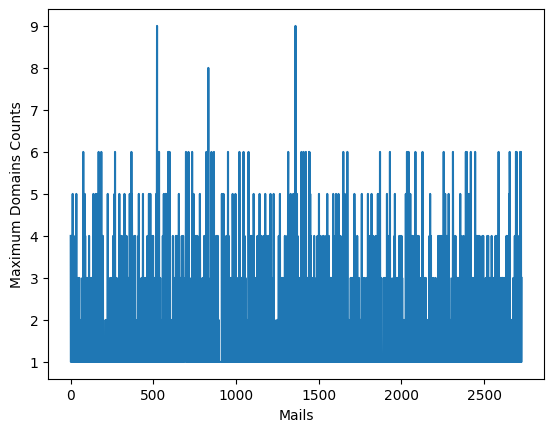

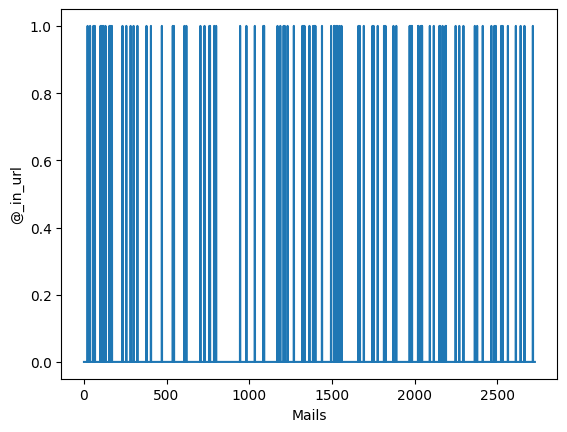

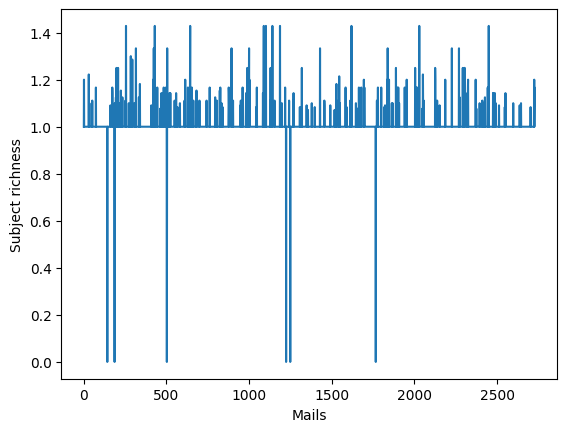

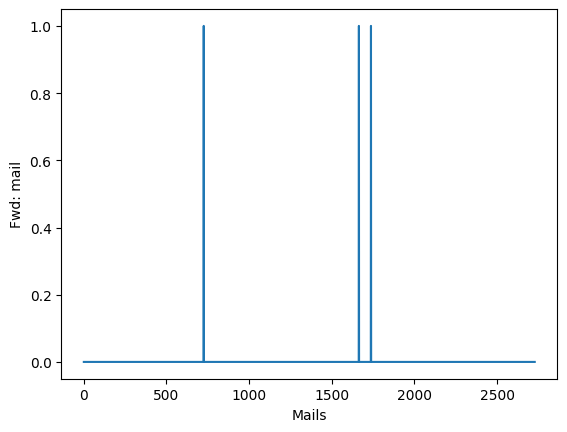

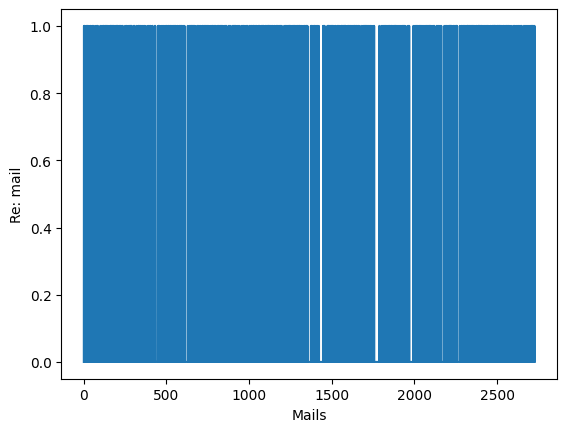

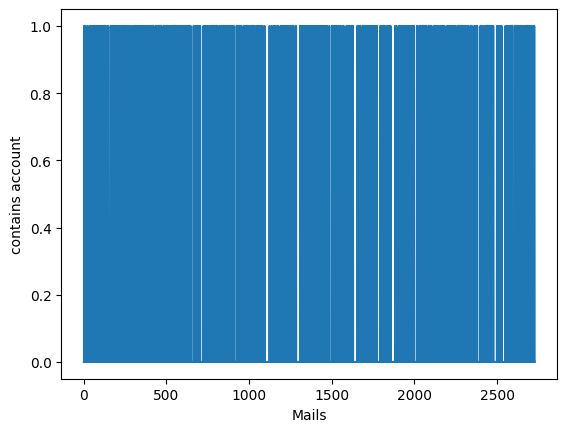

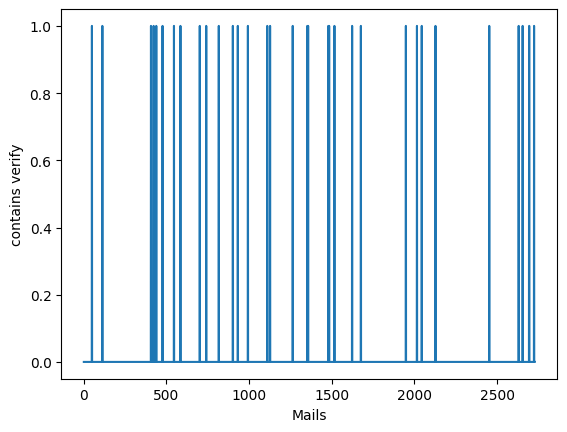

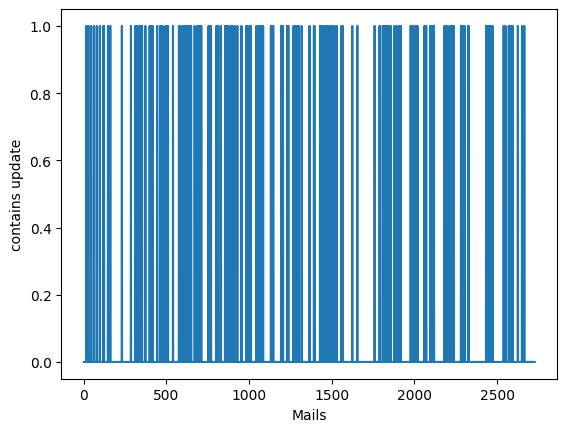

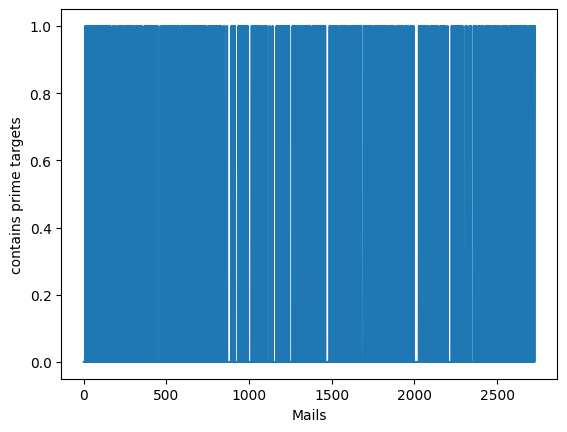

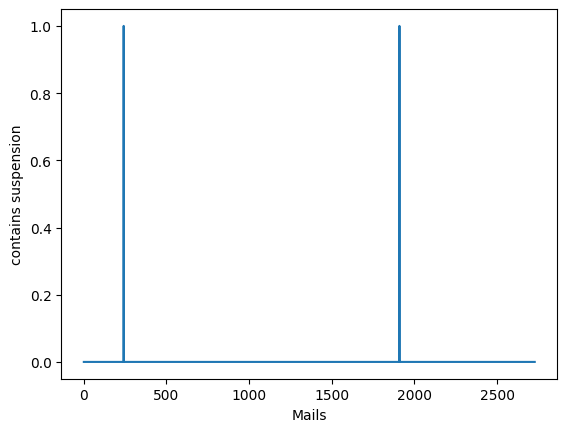

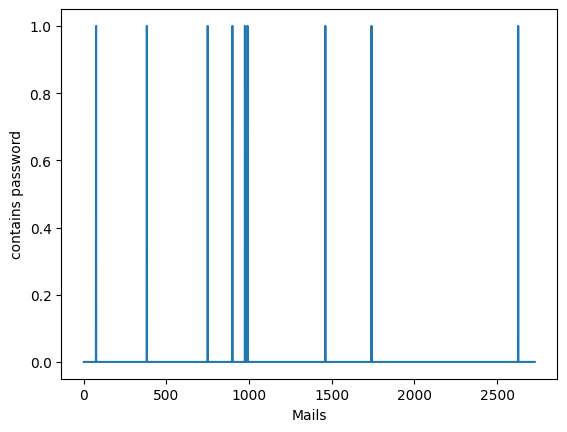

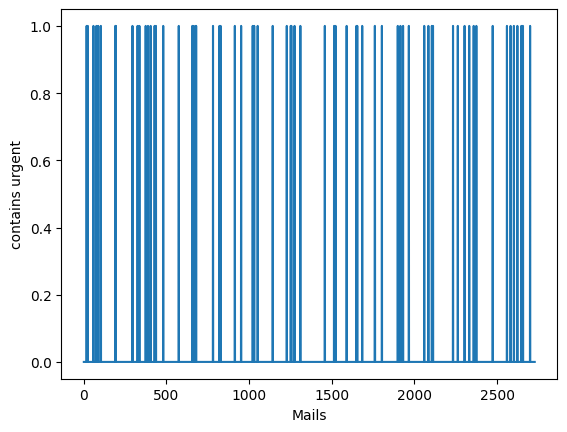

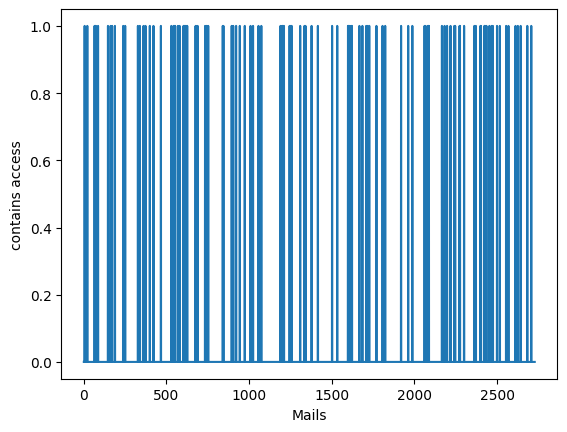

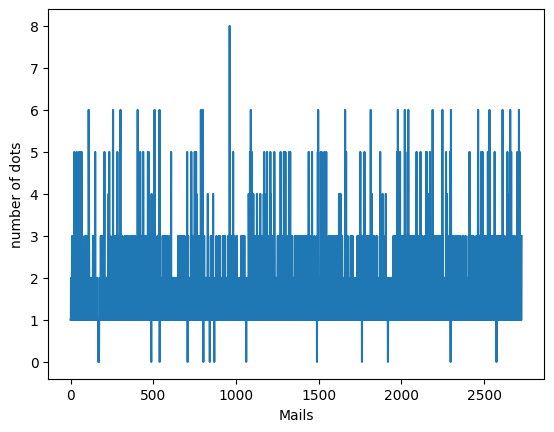

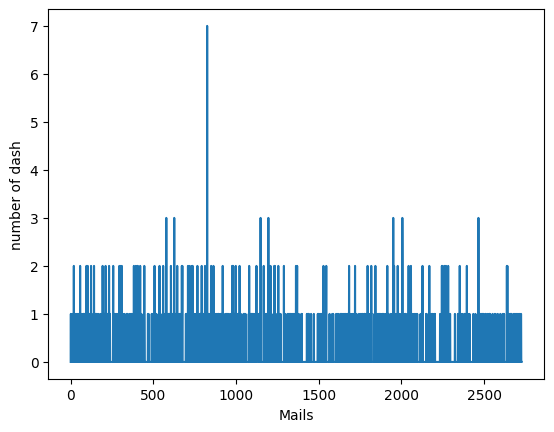

In [48]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_data():
        feature_val = np.array(mails).T
        fields = mails.columns
        xpoints = np.arange(1,len(mails)+1,1)
        for i in range(1,len(fields),1):
            ypoints = np.array(feature_val[i])
            plt.ylabel(fields[i])

            plt.xlabel("Mails")
            plt.plot(xpoints, ypoints)
            plt.show()

visualize_data()
logger.debug("Matplotlib visualization done")

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

data = mails.copy(deep=True)

In [50]:
# initializing the pca
from sklearn import decomposition
import seaborn as sn
from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(data)

data  = standardized_data
pca = decomposition.PCA()

# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_model = pca.fit_transform(data)

# attaching the label for each 2-d data point
pca_data = np.vstack((pca_model.T, labels)).T

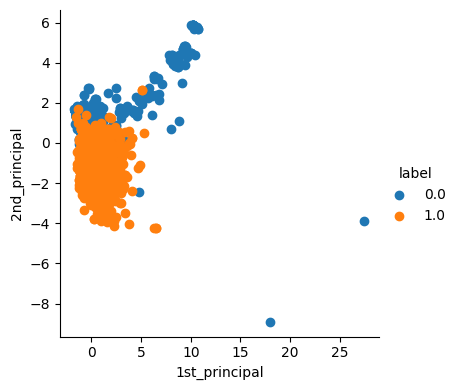

Plotted PCA with components = 2


In [51]:
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", height=4).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()
print("Plotted PCA with components =",pca.n_components)

# logger.debug("Plotted PCA with components = ",pca.n_components)

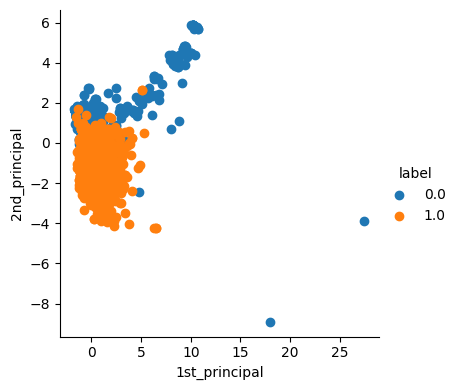

Plotted PCA with components = 2


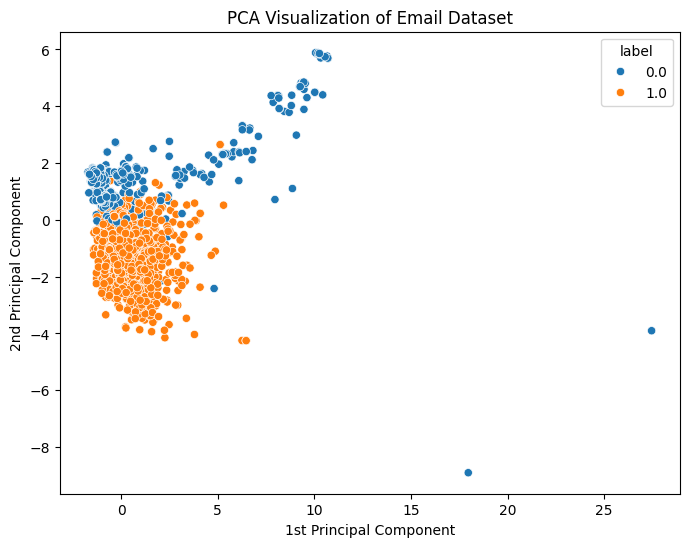

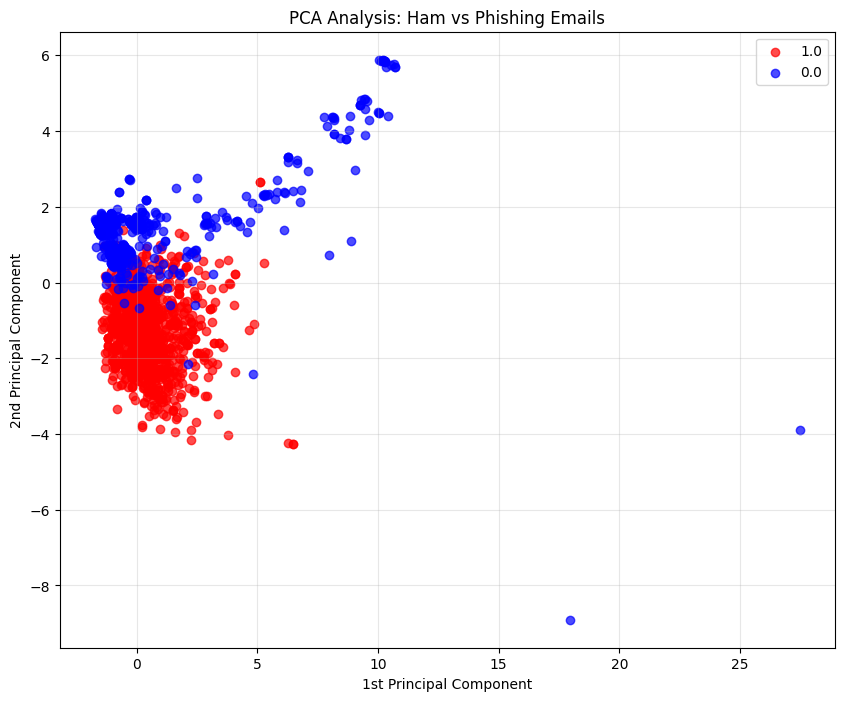

Plotted PCA with components = 2


In [52]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# creating a new data frame which helps us in plotting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))

# Fix: Change 'size' to 'height'
sn.FacetGrid(pca_df, hue="label", height=4).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()
print("Plotted PCA with components =", pca.n_components)

# Alternative: More modern seaborn approach
plt.figure(figsize=(8, 6))
sn.scatterplot(data=pca_df, x='1st_principal', y='2nd_principal', hue='label')
plt.title('PCA Visualization of Email Dataset')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

# Or using matplotlib directly for more control
plt.figure(figsize=(10, 8))
colors = ['red', 'blue']  # Adjust colors as needed
labels = pca_df['label'].unique()

for i, label in enumerate(labels):
    mask = pca_df['label'] == label
    plt.scatter(pca_df[mask]['1st_principal'],
               pca_df[mask]['2nd_principal'],
               c=colors[i],
               label=label,
               alpha=0.7)

plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA Analysis: Ham vs Phishing Emails')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Plotted PCA with components =", pca.n_components)

(3096, 31)


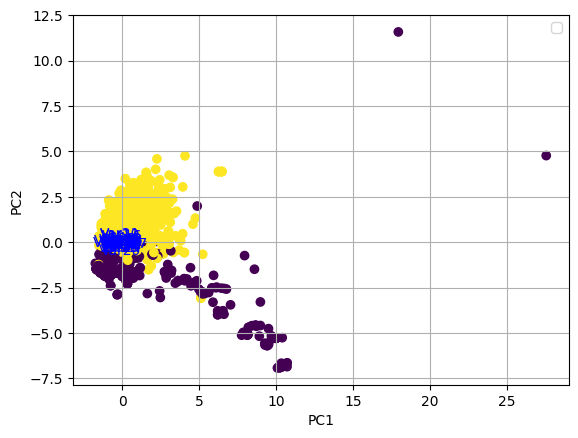

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#In general it is a good idea to scale the data
scaler = StandardScaler()
X =  X_train.copy(deep=True)
y = Y_train.copy()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA()
pca.fit(X,y)
x_new = pca.transform(X)
print(x_new.shape)
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'b', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'r', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.legend()
plt.grid()

#Call the function.
myplot(x_new[:,0:3], pca.components_)
plt.show()

In [54]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np


model = PCA(n_components=4).fit(X_train)
X_pc = model.transform(X_train)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [X_train.columns[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

0                       1
0  PC0          Number of URLs
1  PC1           Malicious URL
2  PC2  Maximum Domains Counts
3  PC3          number of dots

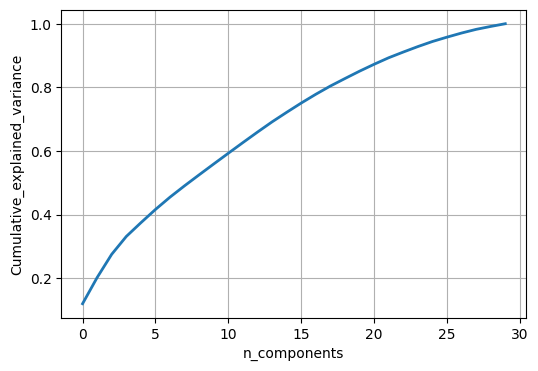

In [55]:
# PCA for dimensionality redcution (non-visualization)

pca.n_components = len(mails.columns)-1
pca_data = pca.fit_transform(data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()
logger.debug("Cumulative explained variance graph plotted")

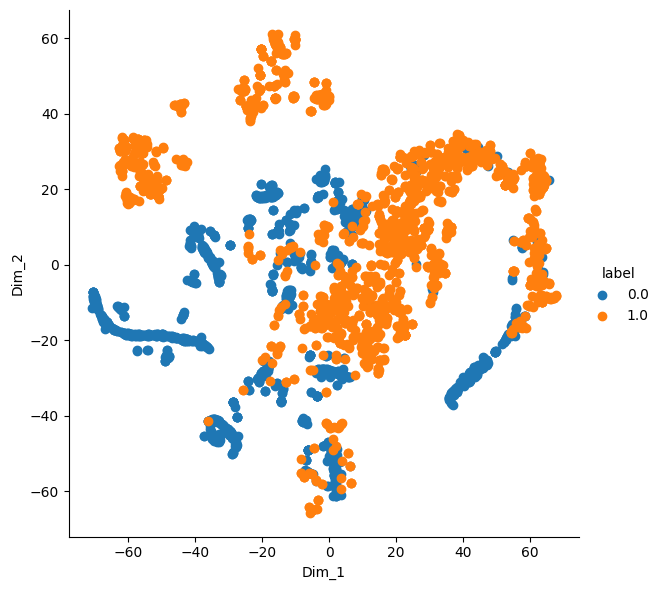

In [56]:
# TSNE

from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_train)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Y_train)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
logger.debug("t-SNE with default configurations plotted")

tsne_data shape: (3096, 2)
Y_train shape: (3096,)


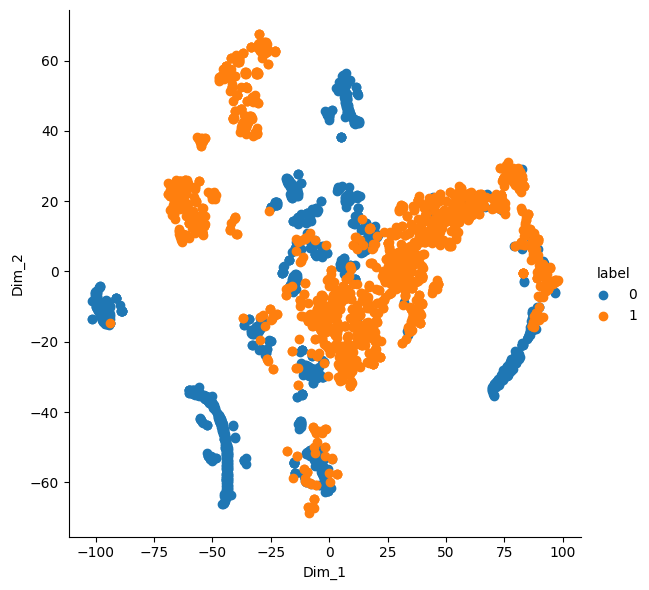

In [57]:
model = TSNE(n_components=2, random_state=0, perplexity=35, n_iter=3500)

tsne_data = model.fit_transform(X_train)

# Debug: Check shapes before combining
print(f"tsne_data shape: {tsne_data.shape}")
print(f"Y_train shape: {Y_train.shape}")

# Method 1: Using pandas (recommended - cleaner and more readable)
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1', 'Dim_2'])
tsne_df['label'] = Y_train

# Method 2: Using numpy vstack (corrected version)
# Y_train_reshaped = Y_train.reshape(1, -1)  # Shape: (1, n_samples)
# tsne_data_combined = np.vstack((tsne_data.T, Y_train_reshaped)).T
# tsne_df = pd.DataFrame(data=tsne_data_combined, columns=("Dim_1", "Dim_2", "label"))

# Plotting the result of t-SNE
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
logger.debug("t-SNE with perplexity = 35 and steps = 3500")

In [ ]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_data = svd.fit_transform(data)

svd_data = np.vstack((svd_data.T, labels)).T
svd_df = pd.DataFrame(data=svd_data, columns=("Dim_1", "Dim_2", "label"))
palette =(zip(svd_data, sns.color_palette()))

palette = sns.color_palette()
sn.FacetGrid(svd_df, hue="label",palette=palette, size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
logger.debug("SVD with default configurations plotted")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2726 and the array at index 1 has size 2

In [58]:
## Remove features with missing values
X_train.isnull().any().any()

np.False_

In [59]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.16))
sel.fit(X_train)
cols = sel.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]
Selected_features_VarianceFilter = features_df_new.columns
Selected_features_VarianceFilter

Index(['HTML', 'body richness', 'Number of URLs', 'Malicious URL',
       'text link disparity', 'IP URLs', 'hexadecimal URL',
       'Maximum Domains Counts', 'Re: mail', 'contains account',
       'contains prime targets', 'number of dots', 'number of dash'],
      dtype='object')

In [60]:
Filtered = X_train[Selected_features_VarianceFilter]

In [61]:
# Option 1: If you want to use RandomForestClassifier (for classification)
from sklearn.ensemble import RandomForestClassifier
X_trainn = Filtered
model = RandomForestClassifier(random_state=42, max_depth=10)
model.fit(X_trainn, Y_train)

# Option 2: If you want to use RandomForestRegressor (for regression)
# from sklearn.ensemble import RandomForestRegressor
# X_trainn = Filtered
# model = RandomForestRegressor(random_state=42, max_depth=10)
# model.fit(X_trainn, Y_train)

# Option 3: Import both if you're unsure
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

RandomForestClassifier(max_depth=10, random_state=42)

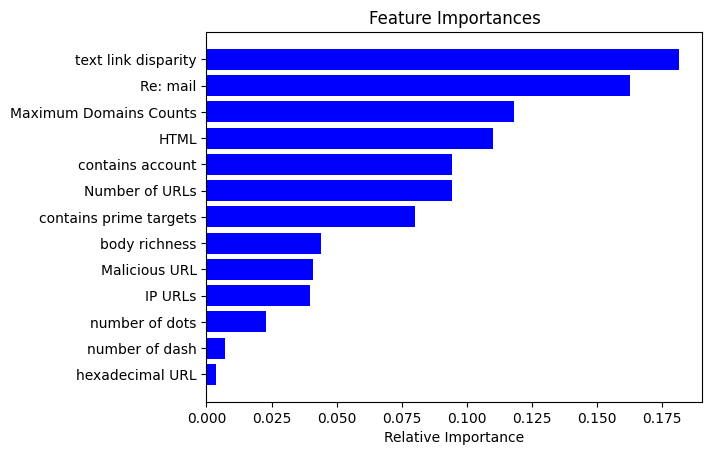

['text link disparity',
 'Re: mail',
 'Maximum Domains Counts',
 'HTML',
 'contains account',
 'Number of URLs',
 'contains prime targets',
 'body richness',
 'Malicious URL',
 'IP URLs',
 'number of dots',
 'number of dash',
 'hexadecimal URL']

In [62]:
features = X_trainn.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-13:]  # top 10 features

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

Selected_features_RandomForestClassifier = [features[index] for index in indices]
Selected_features_RandomForestClassifier.reverse()
Selected_features_RandomForestClassifier

In [63]:
#UNIVARIATE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = X_train, Y_train
selector = SelectKBest(chi2, k=11)
selector.fit(X,y)
# sel.scores_
cols = selector.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]
Selected_features_Univariate = features_df_new.columns
Selected_features_Univariate

Index(['HTML', 'General Salutation', 'mailto:', 'Number of URLs',
       'text link disparity', 'Attachments', 'IP URLs',
       'Maximum Domains Counts', 'Re: mail', 'contains account',
       'contains prime targets'],
      dtype='object')

In [64]:
# Selected_features = ((Selected_features_RandomForestClassifier + Selected_features_Univariate) + Selected_features_VarianceFilter)
# # len(set(Selected_features))
Selected_features = []
Selected_features.extend(Selected_features_RandomForestClassifier)
Selected_features.extend(Selected_features_Univariate)
Selected_features.extend(Selected_features_VarianceFilter)
Selected_features = set(Selected_features)
Selected_features

{'Attachments',
 'General Salutation',
 'HTML',
 'IP URLs',
 'Malicious URL',
 'Maximum Domains Counts',
 'Number of URLs',
 'Re: mail',
 'body richness',
 'contains account',
 'contains prime targets',
 'hexadecimal URL',
 'mailto:',
 'number of dash',
 'number of dots',
 'text link disparity'}

<Axes: >

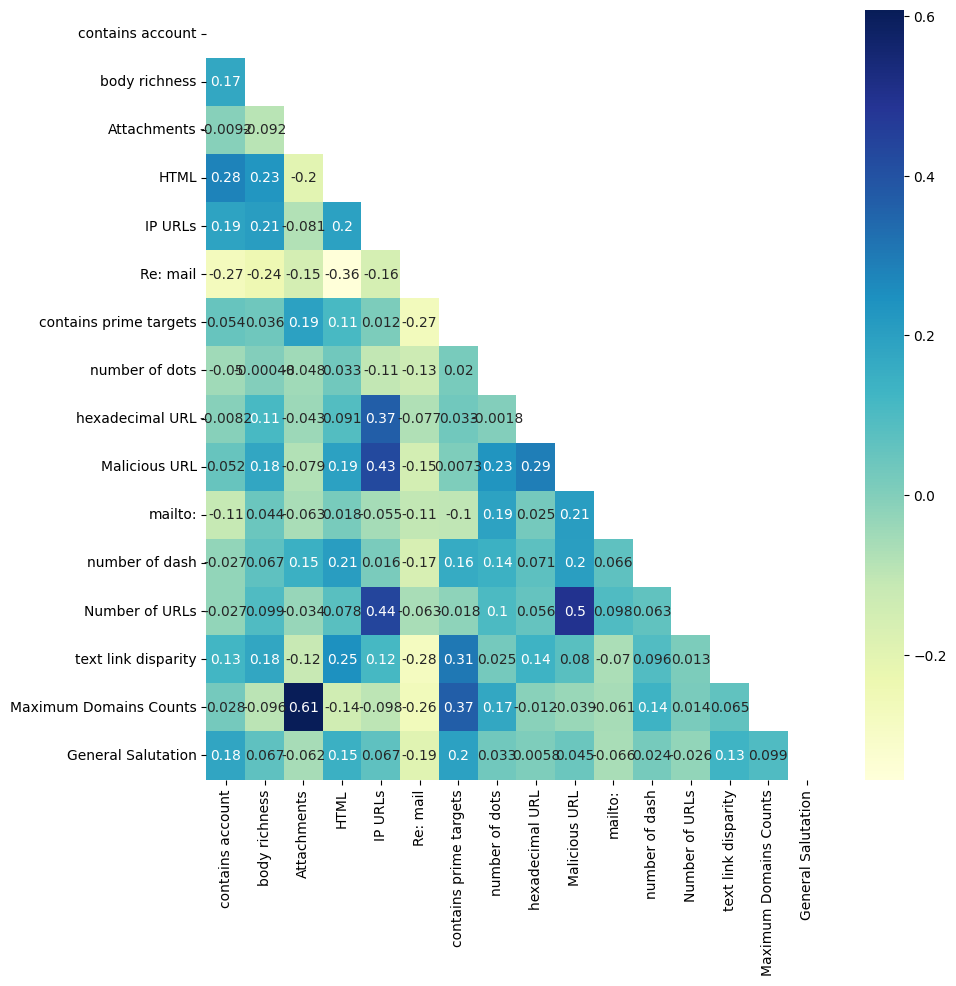

In [65]:
Filtered = X_train[list(Selected_features)]
plt.figure(figsize = (10,10))
# creating mask
mask = np.triu(np.ones_like(Filtered.corr()))


sns.heatmap(Filtered.corr(),annot=True,cmap="YlGnBu", mask=mask)

In [66]:
Selected_features

{'Attachments',
 'General Salutation',
 'HTML',
 'IP URLs',
 'Malicious URL',
 'Maximum Domains Counts',
 'Number of URLs',
 'Re: mail',
 'body richness',
 'contains account',
 'contains prime targets',
 'hexadecimal URL',
 'mailto:',
 'number of dash',
 'number of dots',
 'text link disparity'}

In [67]:
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score,log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score,balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef,roc_auc_score

#Model Select
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from mlxtend.plotting import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [68]:
X_train = X_train[list(Selected_features)]
X_test = X_test[list(Selected_features)]
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [69]:
def training_and_cross_validation(model):

    X = X_train
    y = Y_train

    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    accuracy_list = []
    conf_matrix_list = []

    for train_index, test_index in skf.split(X, y):
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]

        Xtrain = sc.fit_transform(Xtrain)
        Xtest = sc.transform(Xtest)
        model.fit(Xtrain, ytrain)
        predictions = model.predict(Xtest)
        accuracy = accuracy_score(ytest, predictions)
        accuracy_list.append(accuracy)
        CM=confusion_matrix(ytest, predictions)
        conf_matrix_list.append(CM)

    avg_conf_matrix = np.array((pd.DataFrame(np.ceil(np.mean(conf_matrix_list, axis=0)))).astype(int))

    labels =['Ham','Phishing']

    fig, ax = plot_confusion_matrix(conf_mat=avg_conf_matrix,figsize=(4,4),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.title("Average Confusion Matrix after 10 fold validation ")
#     plt.show()
    print('\n')
    mean_accuracy = np.mean(accuracy_list)
    print("Total Average Accuracy is ",np.round(mean_accuracy*100,4),"%")
    return model

In [70]:
MCC = {}
LOG_LOSS = {}
BALANCED_ACCURACY = {}
ACCURACY = {}
F1 = {}
ROC_AUC = {}
REPORT = {}
MODEL = []

In [71]:
def show_performance_metrics(model,name,Xtest=X_test):
    predictions = model.predict(Xtest)


    if name == 'Voting Classifier(hard voting)':
            ll = 'N/A'
    else:
        train_predictions = model.predict_proba(Xtest)
        ll = log_loss(Y_test, train_predictions)
        ll = np.round((ll),3)


    report = classification_report(Y_test, predictions,labels=[0,1],digits=4)
    mcc = np.round(matthews_corrcoef(Y_test,predictions),3)

    roc_auc = np.round(roc_auc_score(Y_test, predictions)*100,3)
    accuracy = np.round(accuracy_score(Y_test, predictions)*100,3)
    balanced_accuracy = np.round(balanced_accuracy_score(Y_test, predictions)*100,3)
    f1 = np.round(f1_score(Y_test, predictions)*100,3)
    MCC[name] = mcc
    LOG_LOSS[name] = ll
    BALANCED_ACCURACY[name] = balanced_accuracy
    ACCURACY[name] = accuracy
    F1[name] = f1
    ROC_AUC[name] = roc_auc
    REPORT[name] = report
    labels = ["Ham","Phishing"]
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,predictions),figsize=(4,4),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    title = "Confusion Matrix : "+name
    plt.title(title)
    plt.show()
    print(report)
    print("MCC: ",mcc)
    print("Log Loss: ",ll)
    print('f1: ',f1)
    print('Balanced Accuracy: ',balanced_accuracy)
    print('Accuracy: ',accuracy)
    print('ROC_AUC : ', roc_auc)

In [72]:
# Libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [73]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=10)
MODEL=[]

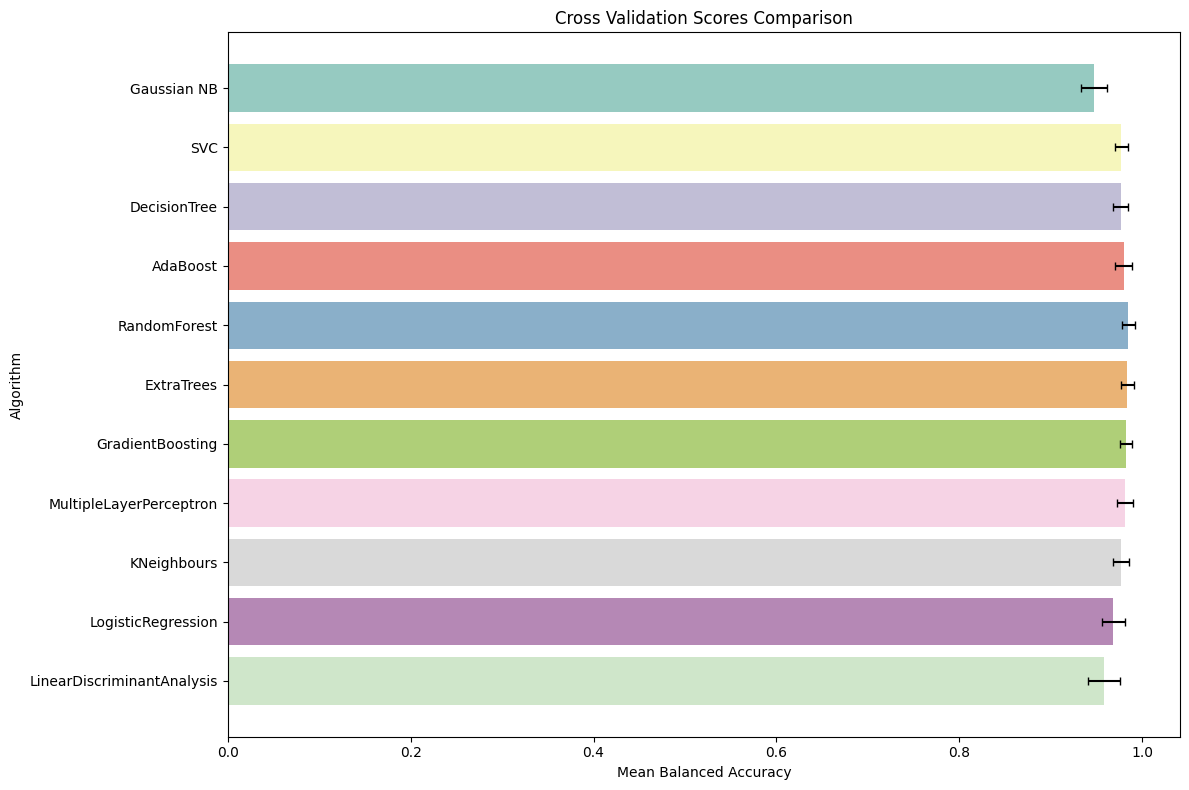


Model Performance Summary:
    CrossValMeans  CrossValerrors                   Algorithm
0          0.9471          0.0140                 Gaussian NB
1          0.9770          0.0072                         SVC
2          0.9762          0.0080                DecisionTree
3          0.9794          0.0092                    AdaBoost
4          0.9847          0.0069                RandomForest
5          0.9837          0.0068                  ExtraTrees
6          0.9822          0.0068            GradientBoosting
7          0.9810          0.0085     MultipleLayerPerceptron
8          0.9766          0.0086                 KNeighbours
9          0.9680          0.0125          LogisticRegression
10         0.9577          0.0176  LinearDiscriminantAnalysis


In [74]:
# Test all the above stated algorithms
random_state = 2
classifiers = []
classifiers.append(GaussianNB())
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="balanced_accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValerrors": cv_std,
    "Algorithm": ["Gaussian NB", "SVC", "DecisionTree", "AdaBoost",
                  "RandomForest", "ExtraTrees", "GradientBoosting",
                  "MultipleLayerPerceptron", "KNeighbours",
                  "LogisticRegression", "LinearDiscriminantAnalysis"]
})

# Fixed barplot syntax - using manual error bars
plt.figure(figsize=(12, 8))
g = sns.barplot(data=cv_res, x="CrossValMeans", y="Algorithm", palette="Set3")

# Add error bars manually
plt.errorbar(cv_res["CrossValMeans"], range(len(cv_res)),
             xerr=cv_std, fmt='none', color='black', capsize=3, capthick=1)

g.set_xlabel("Mean Balanced Accuracy")
g.set_title("Cross Validation Scores Comparison")
plt.tight_layout()
plt.show()

# Print results table for better readability
print("\nModel Performance Summary:")
print(cv_res.round(4))



Total Average Accuracy is  96.8348 %


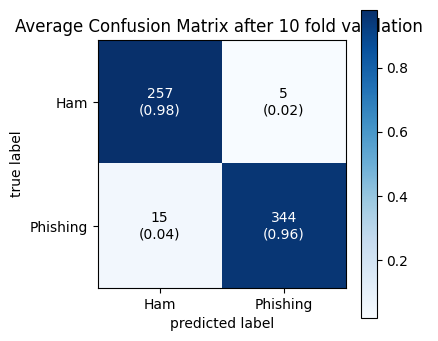

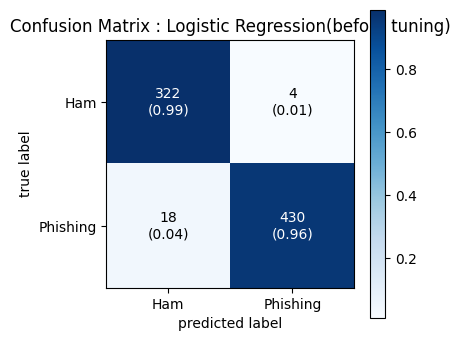

              precision    recall  f1-score   support

           0     0.9471    0.9877    0.9670       326
           1     0.9908    0.9598    0.9751       448

    accuracy                         0.9716       774
   macro avg     0.9689    0.9738    0.9710       774
weighted avg     0.9724    0.9716    0.9716       774

MCC:  0.943
Log Loss:  0.119
f1:  97.506
Balanced Accuracy:  97.378
Accuracy:  97.158
ROC_AUC :  97.378


In [75]:
lr = LogisticRegression()
lr = training_and_cross_validation(lr)
MODEL.append("Logistic Regression(before tuning)")
show_performance_metrics(lr,MODEL[-1])



Total Average Accuracy is  97.4806 %


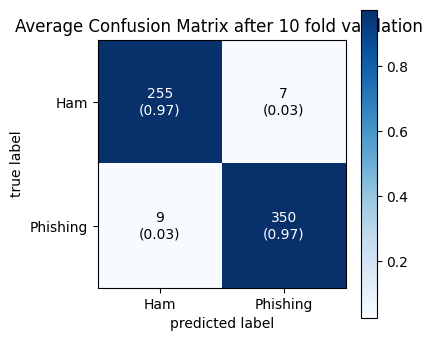

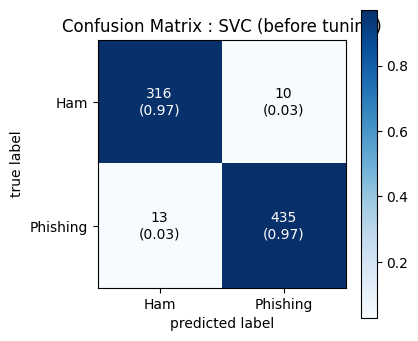

              precision    recall  f1-score   support

           0     0.9605    0.9693    0.9649       326
           1     0.9775    0.9710    0.9742       448

    accuracy                         0.9703       774
   macro avg     0.9690    0.9702    0.9696       774
weighted avg     0.9704    0.9703    0.9703       774

MCC:  0.939
Log Loss:  0.086
f1:  97.424
Balanced Accuracy:  97.015
Accuracy:  97.028
ROC_AUC :  97.015


In [76]:
svc = SVC(probability=True)
svc = training_and_cross_validation(svc)
MODEL.append('SVC (before tuning)')
show_performance_metrics(svc,MODEL[-1])



Total Average Accuracy is  98.3204 %


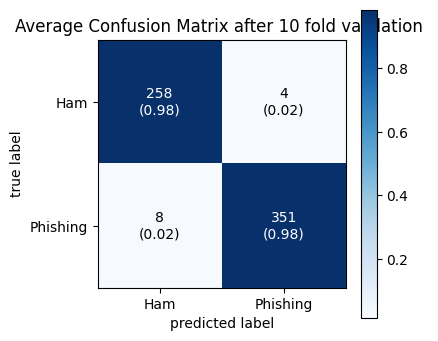

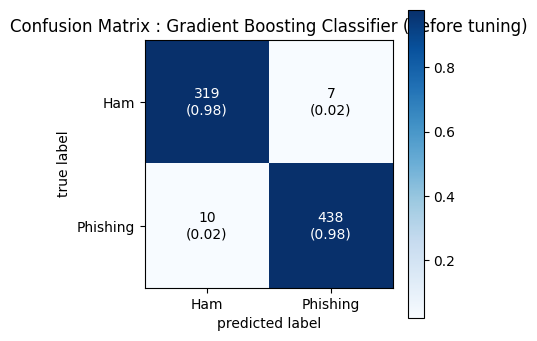

              precision    recall  f1-score   support

           0     0.9696    0.9785    0.9740       326
           1     0.9843    0.9777    0.9810       448

    accuracy                         0.9780       774
   macro avg     0.9769    0.9781    0.9775       774
weighted avg     0.9781    0.9780    0.9780       774

MCC:  0.955
Log Loss:  0.069
f1:  98.096
Balanced Accuracy:  97.81
Accuracy:  97.804
ROC_AUC :  97.81


In [77]:
gbc = GradientBoostingClassifier()
gbc = training_and_cross_validation(gbc)
MODEL.append('Gradient Boosting Classifier (before tuning)')
show_performance_metrics(gbc,MODEL[-1])



Total Average Accuracy is  98.3204 %


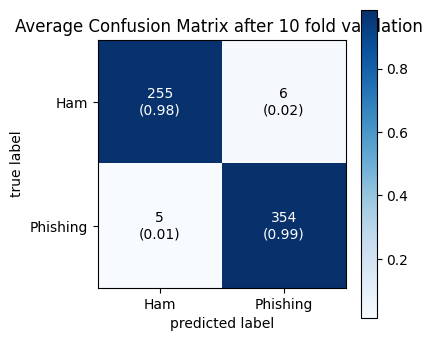

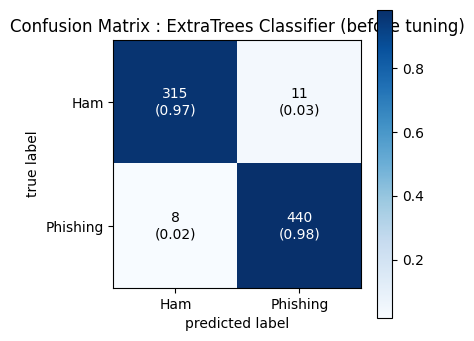

              precision    recall  f1-score   support

           0     0.9752    0.9663    0.9707       326
           1     0.9756    0.9821    0.9789       448

    accuracy                         0.9755       774
   macro avg     0.9754    0.9742    0.9748       774
weighted avg     0.9755    0.9755    0.9754       774

MCC:  0.95
Log Loss:  0.066
f1:  97.887
Balanced Accuracy:  97.42
Accuracy:  97.545
ROC_AUC :  97.42


In [78]:
extc = ExtraTreesClassifier()
extc = training_and_cross_validation(extc)
MODEL.append('ExtraTrees Classifier (before tuning)')
show_performance_metrics(extc,MODEL[-1])



Total Average Accuracy is  98.4173 %


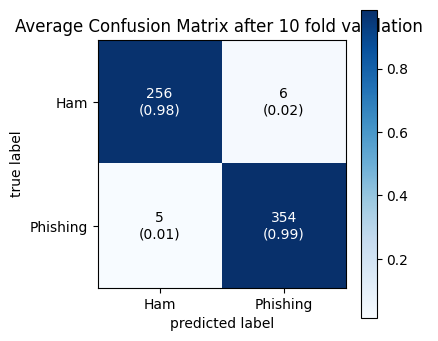

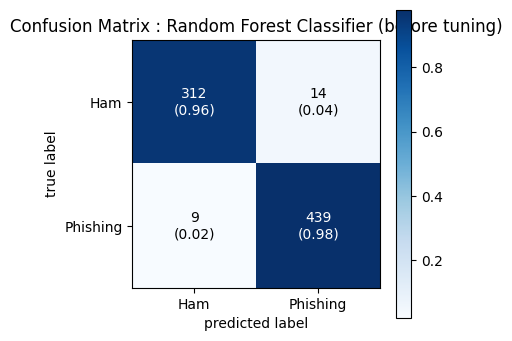

              precision    recall  f1-score   support

           0     0.9720    0.9571    0.9645       326
           1     0.9691    0.9799    0.9745       448

    accuracy                         0.9703       774
   macro avg     0.9705    0.9685    0.9695       774
weighted avg     0.9703    0.9703    0.9703       774

MCC:  0.939
Log Loss:  0.067
f1:  97.447
Balanced Accuracy:  96.848
Accuracy:  97.028
ROC_AUC :  96.848


In [79]:
rf_c = RandomForestClassifier()
rf_c  = training_and_cross_validation(rf_c )
MODEL.append('Random Forest Classifier (before tuning)')
show_performance_metrics(rf_c,MODEL[-1])

In [80]:
kfold = 10


In [81]:
#ExtraTrees
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="balanced_accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


np.float64(0.9858471521939046)

ExtraTreesClassifier(max_features=3, min_samples_split=10, n_estimators=300)


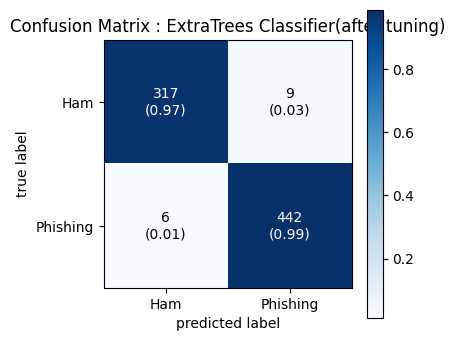

              precision    recall  f1-score   support

           0     0.9814    0.9724    0.9769       326
           1     0.9800    0.9866    0.9833       448

    accuracy                         0.9806       774
   macro avg     0.9807    0.9795    0.9801       774
weighted avg     0.9806    0.9806    0.9806       774

MCC:  0.96
Log Loss:  0.06
f1:  98.331
Balanced Accuracy:  97.95
Accuracy:  98.062
ROC_AUC :  97.95


In [82]:
MODEL.append("ExtraTrees Classifier(after tuning)")
print(ExtC_best)
show_performance_metrics(gsExtC,MODEL[-1],X_test)

In [ ]:
# RFC Parameters tunning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini","entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


In [ ]:
# MODEL.append("Random Forest(after tuning)")
print(RFC_best)
show_performance_metrics(gsRFC,"Random Forest(after tuning)",X_test)